In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

легрейчик момент

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import plotly.express as px
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(context='talk', style='whitegrid', palette='pastel')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.autolayout'] = 'true'
plt.rcParams['figure.frameon'] = 'false'
plt.rcParams['axes.spines.left'] = 'false'
plt.rcParams['axes.spines.right'] = 'false'
plt.rcParams['axes.spines.top'] = 'false'
plt.rcParams['legend.fancybox'] = 'false'
plt.rcParams['axes.spines.bottom'] = 'false'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'bold'

pd.set_option('display.max_columns', 60)

In [2]:
cv = pd.read_excel("База Пермь.xlsx")

In [3]:
df = cv.copy()
df = df.drop_duplicates(subset='call_id')
print(df.shape)
df = df[df['voice_offer_flag'] == 1]
df.shape

(149756, 36)


(40480, 36)

In [4]:
df.isna().sum()

call_id                         0
client_id                       0
employee_id                     0
offer_type                      0
offer_time_sec                491
voice_offer_flag                0
application_flag                0
utilization_flag                0
utilization_dt              38907
client_agree_flg             2792
wait_time_sec                   0
appeal_time_sec                 0
employee_dialog_time_sec        0
repeated_appeal_flg             0
negative_flg                    0
call_dttm                       0
csat_score                  36080
transfer_flg                    0
task_flg                        0
problem_status_code         16388
client_age                      6
client_gender                 210
client_education            20886
сlient_city                 17258
marital_status_cd           16106
children_cnt                14621
foreign_flg                     0
suppress_call_flg             951
suppress_email_flg            951
suppress_limit

In [5]:
# убираем наны в предикторе
df = df[df['problem_status_code'].notna()]
df['problem_status_code'].value_counts()

problem_status_code
UNRESOLVED    13035
RESOLVED      11057
Name: count, dtype: int64

In [6]:
#меняем унресолвед на 0 и ресолвед на 1
mapping = {'UNRESOLVED': 0, 'RESOLVED': 1}

# Применяем замену к нужной колонке
df['problem_status_code'] = df['problem_status_code'].map(mapping)

In [7]:
grouped = df.groupby('problem_status_code').agg({
    'application_flag' : 'mean',
    'employee_dialog_time_sec' : 'mean',
    'problem_status_code' : 'mean'
})



групируем в аппл_флаг теперь конверсия по проблемс_коду, в емплои_сек среднее время звонка по проблемс_коду в проблемс_коде остался проблемс_код

<Axes: xlabel='problem_status_code', ylabel='employee_dialog_time_sec'>

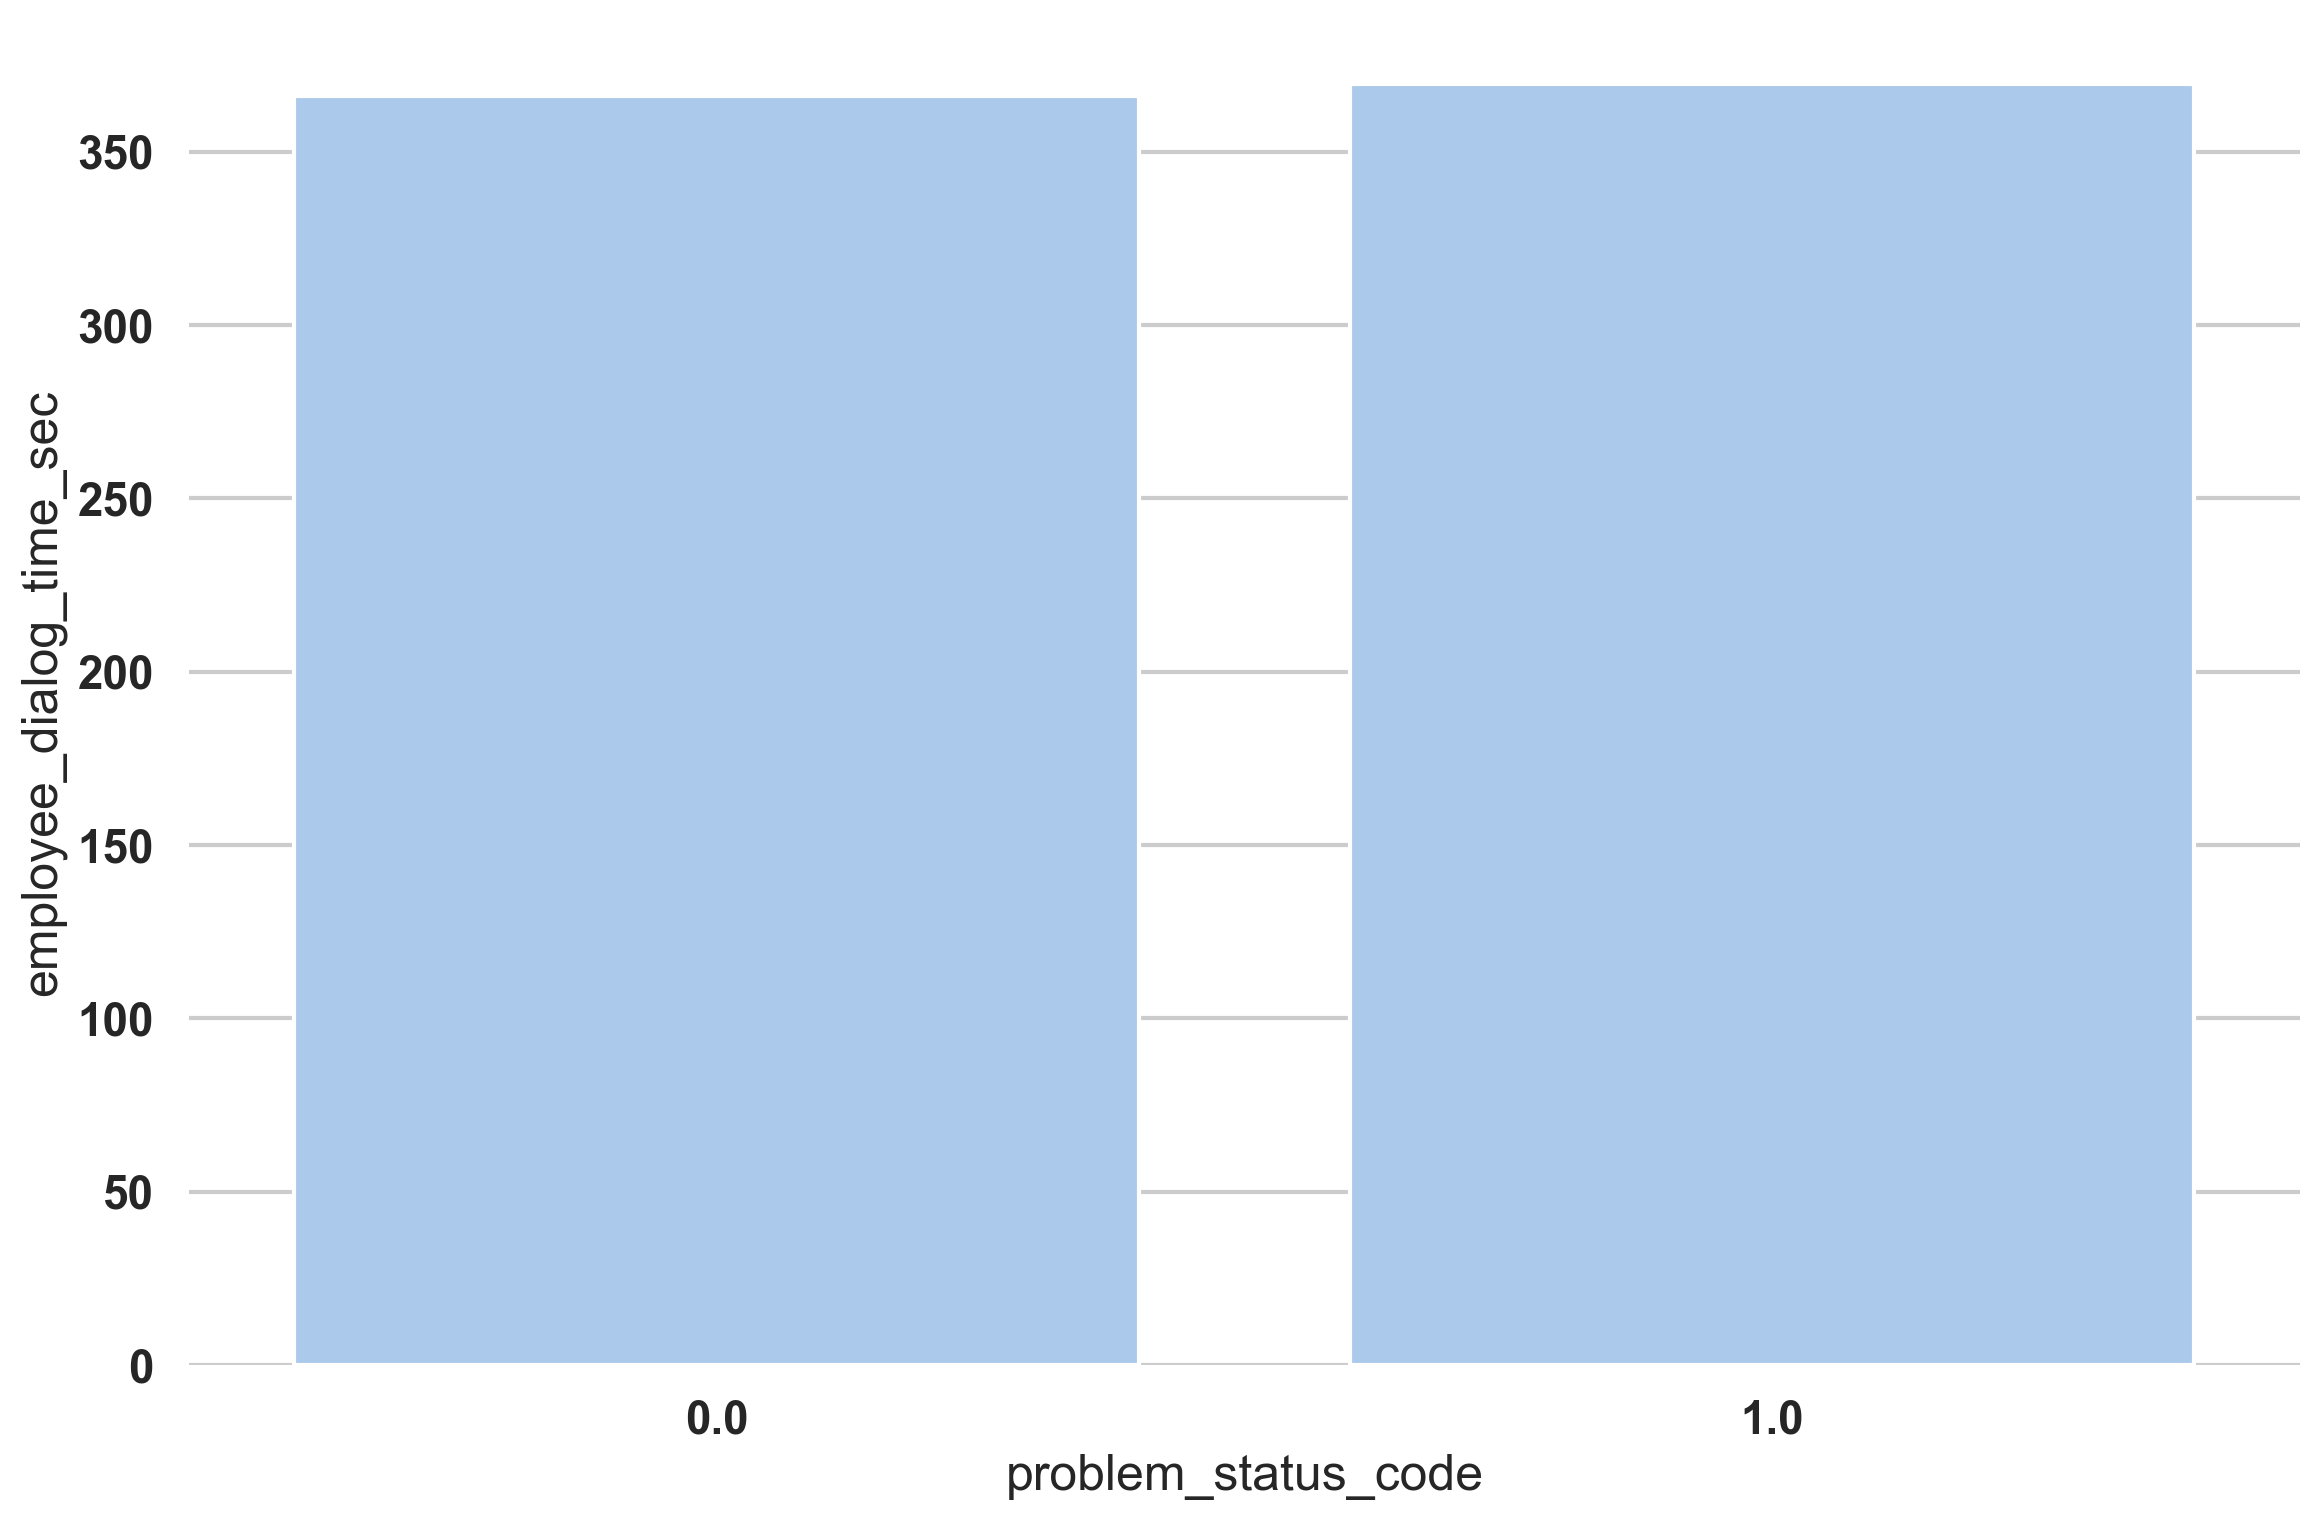

In [8]:
sns.barplot(x='problem_status_code', y='employee_dialog_time_sec', data=grouped)


как видим от успеха решения проблемы не зависит время звонка

<Axes: xlabel='problem_status_code', ylabel='costs_on_appl'>

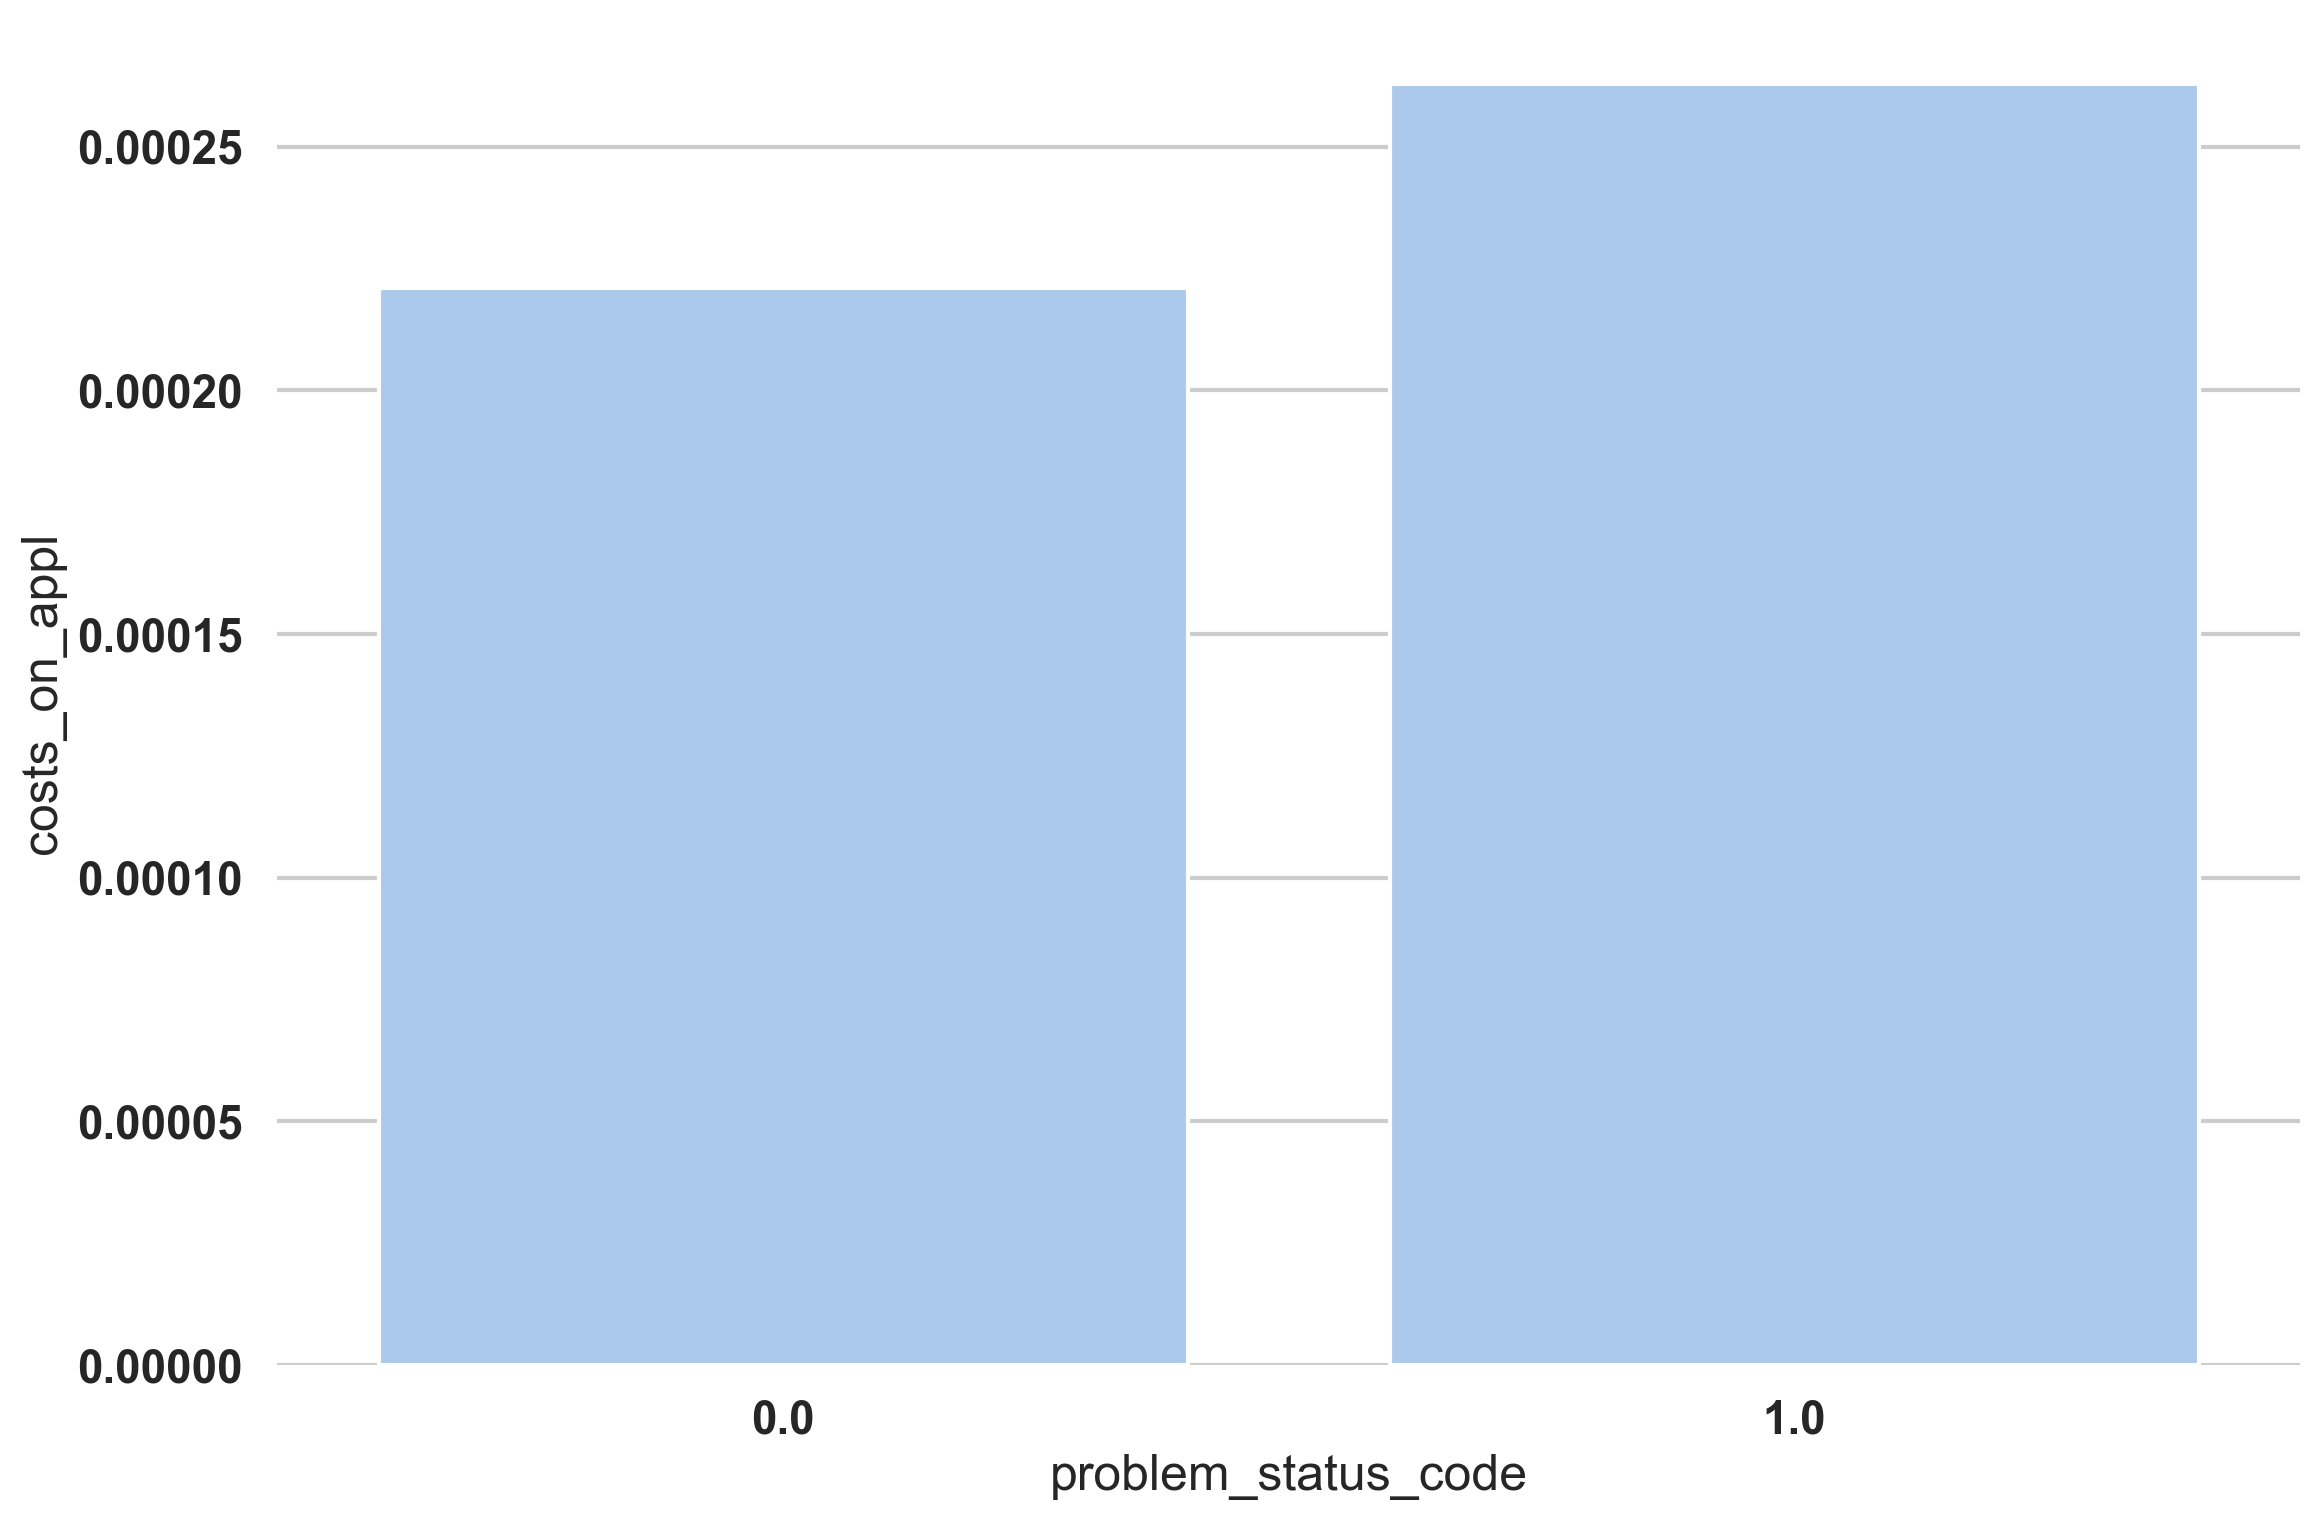

In [9]:
grouped['costs_on_appl'] = grouped['application_flag'] / grouped['employee_dialog_time_sec']
sns.barplot(x='problem_status_code', y='costs_on_appl', data=grouped)
#как видим зависимость

често хз че дальше произошло но ттест показал пвалью 0, ттест сделан)
инфа от дикпика Пошаговое решение:

    Проверка данных:
Убедитесь, что в каждой категории a нет нулевых средних значений c, чтобы избежать деления на ноль.
При необходимости исключите группы с mean(c) = 0.

    Пермутационный тест:
Нулевая гипотеза: Отношение mean(b) / mean(c) не зависит от a.
Альтернативная гипотеза: Зависимость статистически значима.

    Статистика: Дисперсия отношений mean(b) / mean(c) по группам a.
Количество пермутаций: Увеличьте до 100 000 для точности p-value до 4 знака.
Обработка нулей: Если в пермутациях встречается mean(c) = 0, замените отношение на большое число (например, 1e10 или -1e10) для сохранения дисперсии.

    Бутстреп доверительных интервалов:
Для каждой группы a постройте 95% доверительные интервалы для отношения mean(b) / mean(c) using бутстреп.
Визуализируйте интервалы: если они не перекрываются, это указывает на значимые различия.

p-value: 0.0


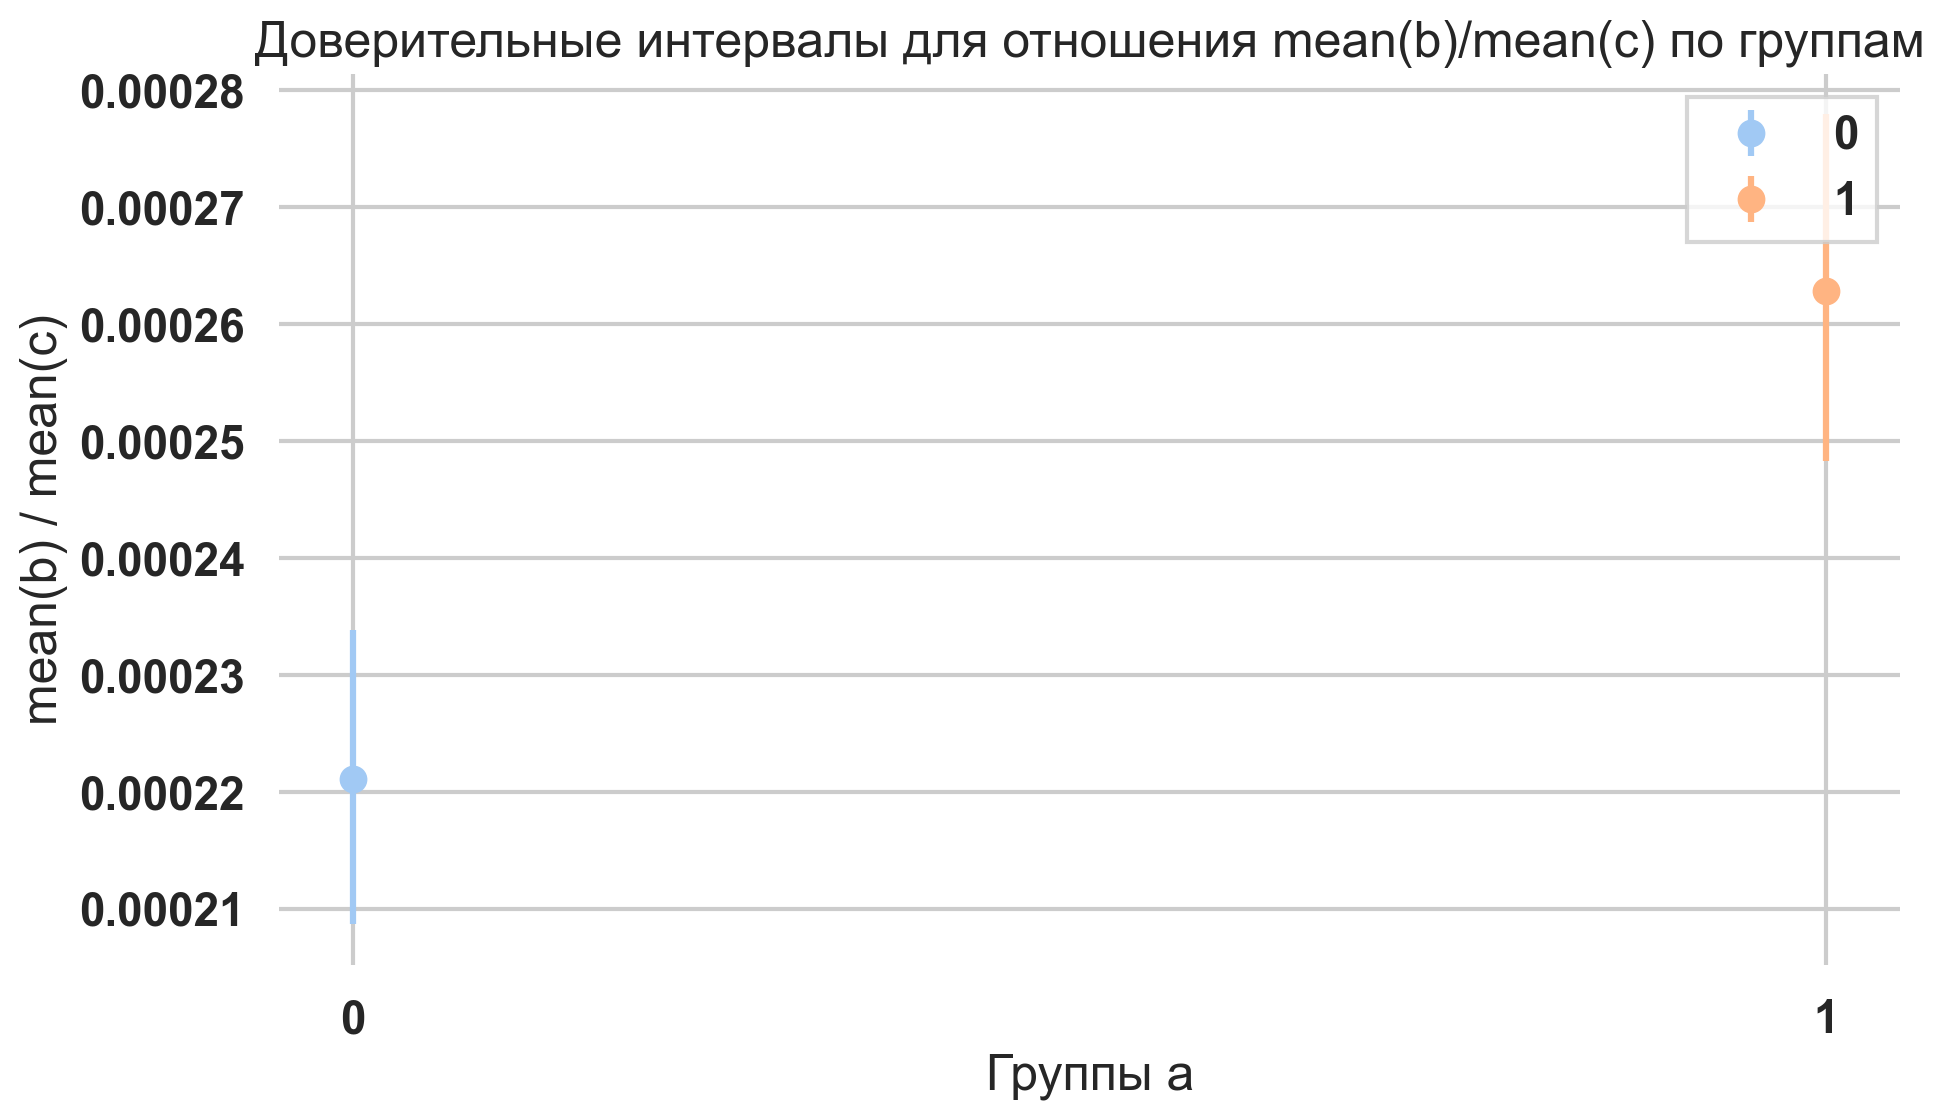

In [10]:
R_observed = []
gr = df.groupby('problem_status_code')
for name, group in gr:
    mean_b = group['application_flag'].mean()
    mean_c = group['employee_dialog_time_sec'].mean()
    R_observed.append(mean_b / mean_c)
T_observed = np.var(R_observed)

# Пермутационный тест
n_perm = 10000
T_permutations = []
for _ in range(n_perm):
    df_perm = df.copy()
    df_perm['problem_status_code'] = np.random.permutation(df['problem_status_code'])
    groups_perm = df_perm.groupby('problem_status_code')
    R_perm = []
    for name, group in groups_perm:
        mean_b_perm = group['application_flag'].mean()
        mean_c_perm = group['employee_dialog_time_sec'].mean()
        if mean_c_perm == 0:
            continue
        R_perm.append(mean_b_perm / mean_c_perm)
    if len(R_perm) > 0:
        T_permutations.append(np.var(R_perm))

p_value = np.mean(T_permutations >= T_observed)
print(f"p-value: {p_value}")

# Бутстреп доверительных интервалов
def bootstrap_ratio(group, n_bootstrap=10000):
    ratios = []
    n = len(group)
    for _ in range(n_bootstrap):
        sample = group.sample(n, replace=True)
        mean_b = sample['application_flag'].mean()
        mean_c = sample['employee_dialog_time_sec'].mean()
        if mean_c != 0:
            ratios.append(mean_b / mean_c)
    return ratios

boot_results = {}
for name, group in gr:
    ratios = bootstrap_ratio(group)
    boot_results[name] = ratios

# Визуализация
plt.figure(figsize=(10, 6))
for i, (name, ratios) in enumerate(boot_results.items()):
    mean_ratio = np.mean(ratios)
    ci_low = np.percentile(ratios, 2.5)
    ci_high = np.percentile(ratios, 97.5)
    plt.errorbar(i, mean_ratio, yerr=[[mean_ratio - ci_low], [ci_high - mean_ratio]], fmt='o', label=name)
plt.xticks(range(len(boot_results)), list(boot_results.keys()))
plt.xlabel('Группы a')
plt.ylabel('mean(b) / mean(c)')
plt.title('Доверительные интервалы для отношения mean(b)/mean(c) по группам')
plt.legend()
plt.show()

проверяем на устойчивость
у нас 20000 нанов в строке client_education, поэтому ее не юзаем
юзаем employee_type, employee_gende, client_gender, client_age

    Стратификация по категориальным переменным:
Мы проверяем устойчивость результата, разделяя данные на подгруппы по каждой категориальной переменной
Для client_age создаются квантили (4 группы)

    Пермутационный тест на подмножествах:
Для каждой подгруппы проводится тот же пермутационный тест, что и для всего датасета
Учитываются только подгруппы с достаточным количеством данных (>30 наблюдений)

    Индивидуальные p-value для каждой категории:
Теперь код сохраняет и выводит p-value для каждой категории отдельно
Для каждой категории выводится значение p-value и обозначение статистической значимости (*** для p < 0.001, ** для p < 0.01, * для p < 0.05)

    Анализ комбинаций переменных:
Дополнительно проверяются комбинации наиболее важных переменных

    Улучшенный вывод результатов:
Результаты сгруппированы по переменным
Для каждой категории указывается, достаточно ли данных для анализа

    Визуализация результатов:
Добавлены столбчатые диаграммы, показывающие p-value для каждой категории
Использована логарифмическая шкала для лучшего отображения малых p-value
Красная пунктирная линия показывает уровень значимости 0.05
Столбцы окрашены в красный цвет для значимых результатов (p < 0.05) и в синий для незначимых

    Анализ комбинаций переменных:
Для важных комбинаций переменных также выводятся индивидуальные p-value

Результаты проверки устойчивости по категориям:

employee_type:
  ГПД: p-value = 0.154000 
  ТК: p-value = 0.000000 ***
  ПКЦ: p-value = 0.170000 
  Прочие: недостаточно данных для анализа

employee_gender:
  Мужчина: p-value = 0.001000 **
  Женщина: p-value = 0.001000 **

client_gender:
  M: p-value = 0.000000 ***
  F: p-value = 0.014000 *
  nan: недостаточно данных для анализа

client_age_group:
  38.0: p-value = 0.018000 *
  22.0: p-value = 0.004000 **
  29.0: p-value = 0.012000 *
  41.0: p-value = 0.014000 *
  53.0: p-value = 0.309000 
  60.0: p-value = 0.549000 
  48.0: p-value = 0.403000 
  34.0: p-value = 0.465000 
  103.0: p-value = 0.891000 
  44.0: p-value = 0.065000 
  nan: недостаточно данных для анализа

Анализ для комбинаций переменных:

Комбинация: employee_type & employee_gender
  ('ГПД', 'Женщина'): p-value = 0.292000 
  ('ГПД', 'Мужчина'): p-value = 0.232000 
  ('ПКЦ', 'Женщина'): p-value = 0.319000 
  ('ПКЦ', 'Мужчина'): p-value = 0.285000 
  ('Прочие', 'Женщина'): н

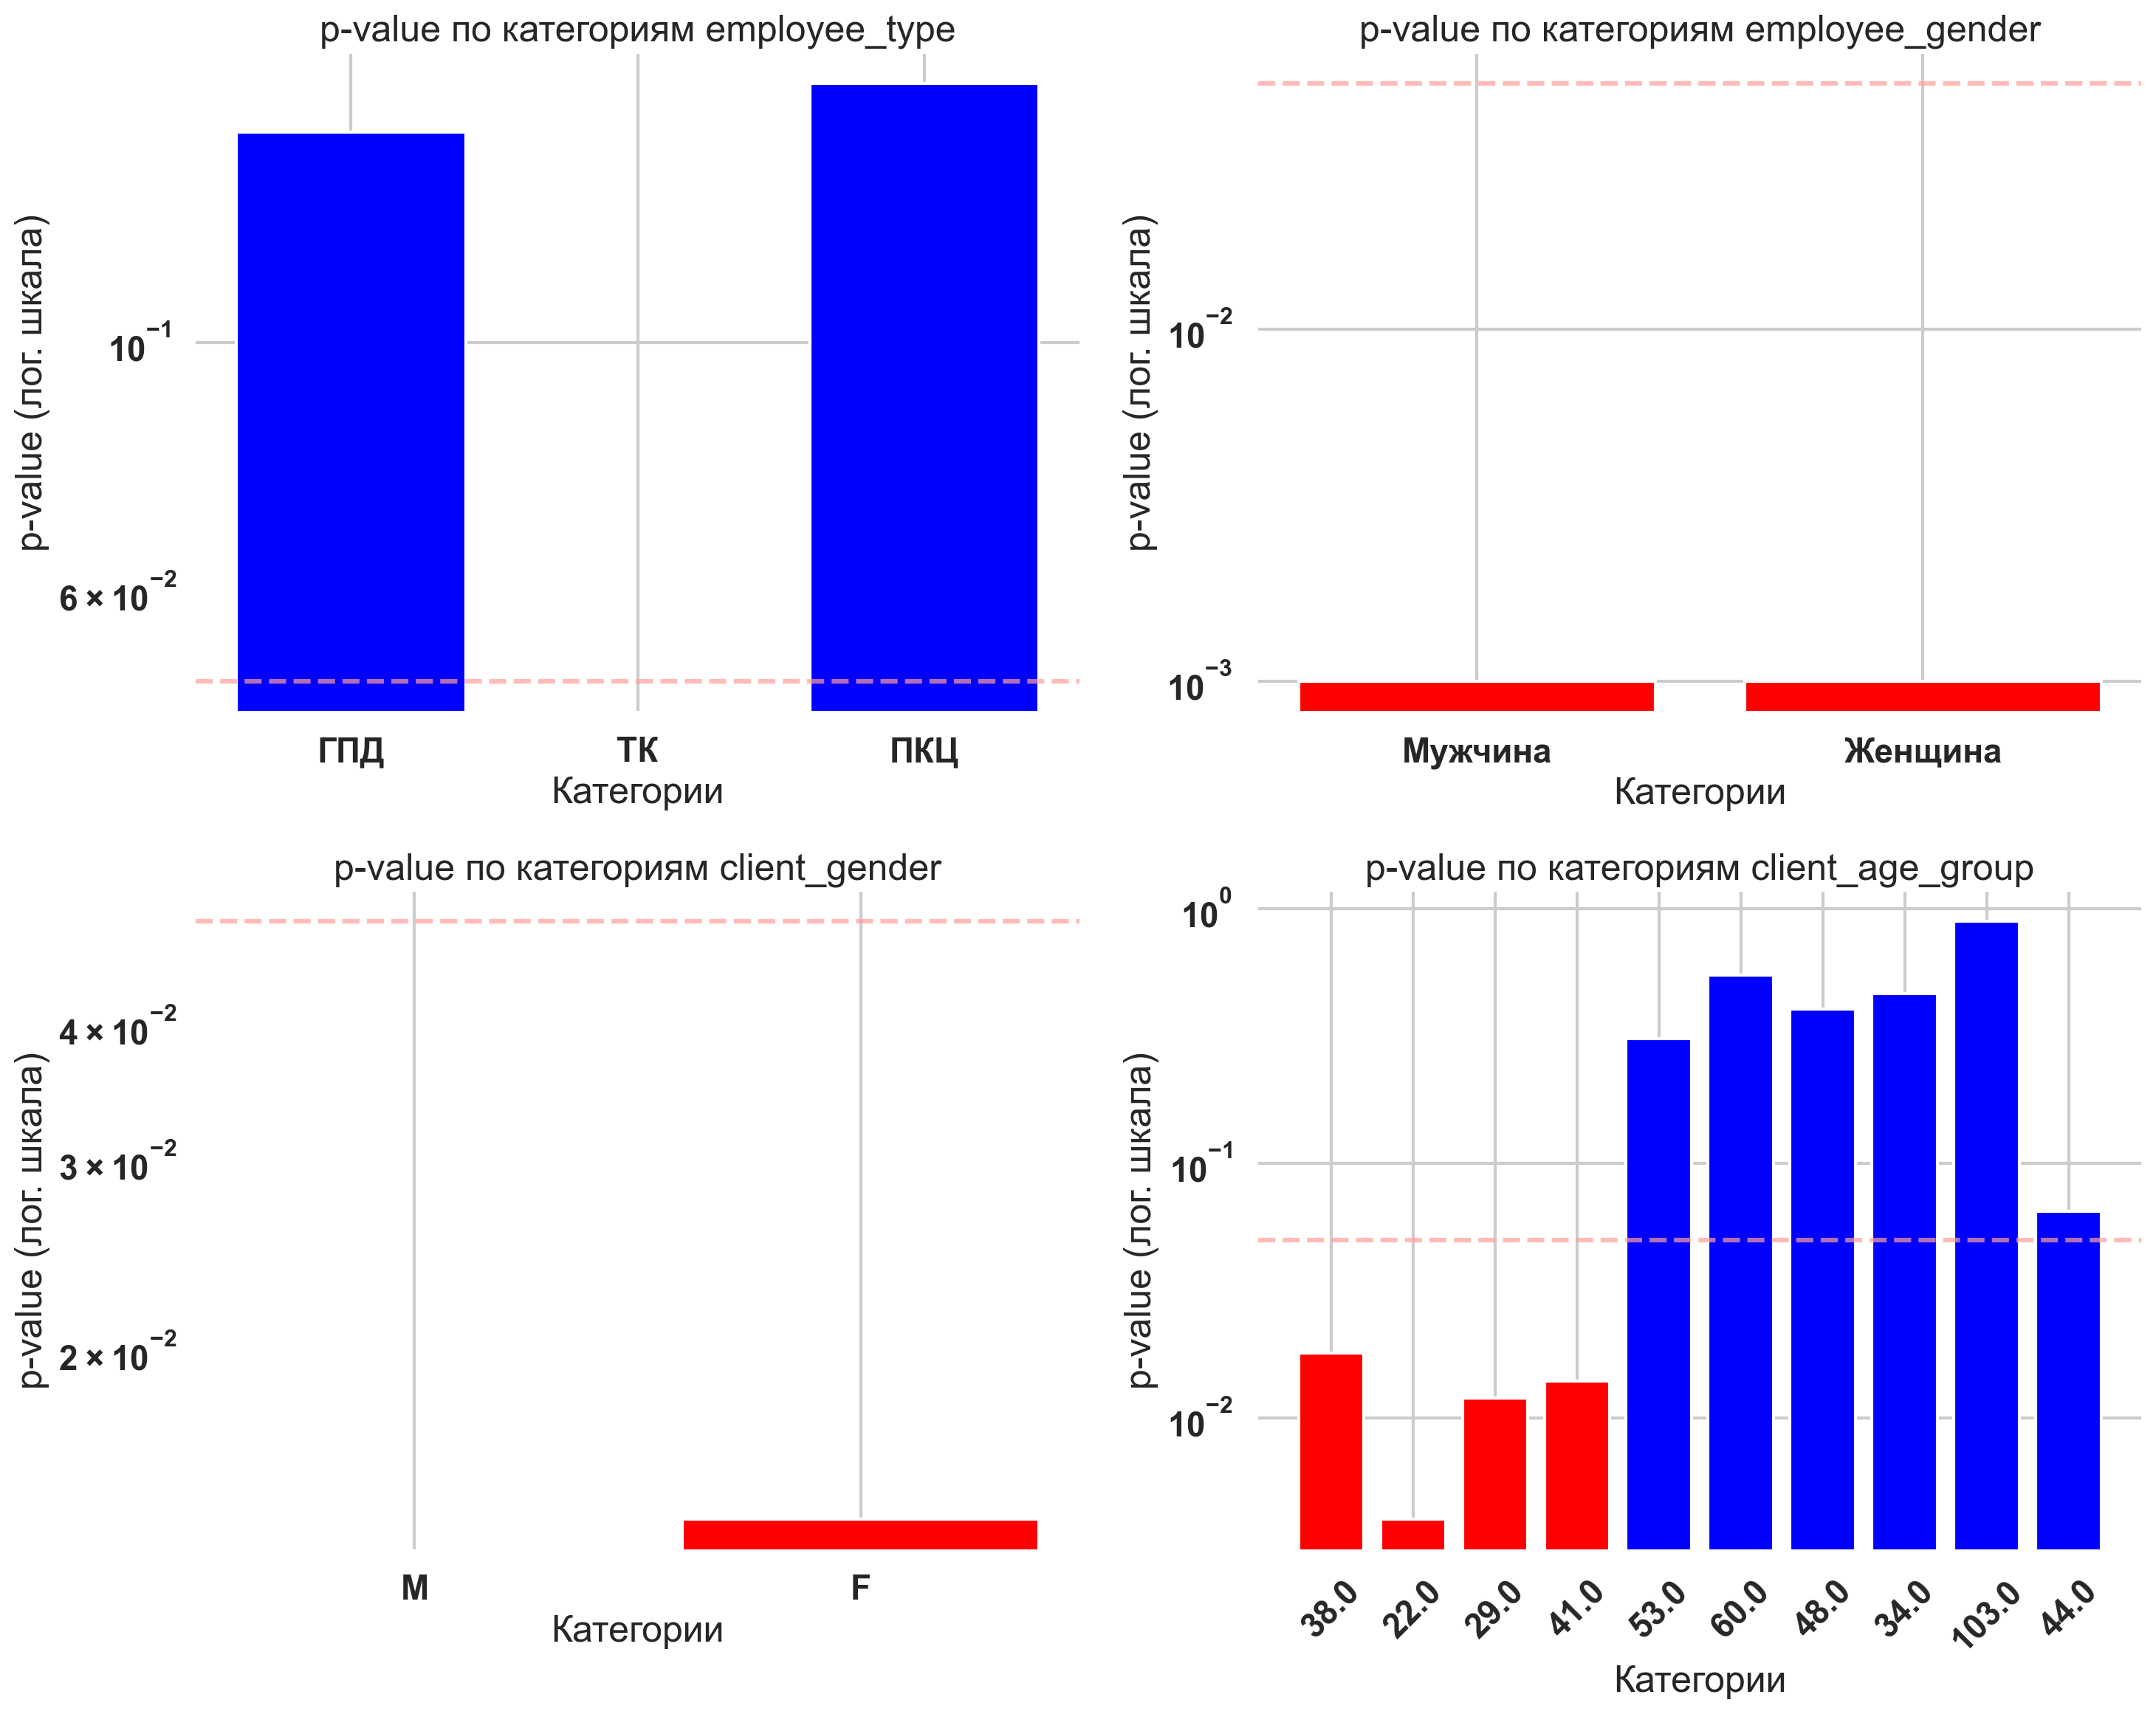

In [11]:
# Проверка устойчивости: стратифицированный анализ с выводом p-value для каждой категории
variables_to_check = ['employee_type', 'employee_gender', 'client_gender']

# Создание квантилей для client_age
age_quantiles = pd.qcut(df['client_age'], q=10, retbins=True)
age_bins = age_quantiles[1]
age_midpoints = [age_bins[i+1] for i in range(len(age_bins)-1)]

# Создание новой переменной с серединами отрезков
df['client_age_group'] = pd.qcut(df['client_age'], q=10, labels=age_midpoints)
variables_to_check.append('client_age_group')  # Добавляем в список переменных для проверки

# Функция для проведения пермутационного теста на подмножестве данных
def run_permutation_test_on_subset(subset, n_perm=1000):
    if len(subset) < 30:  # Минимальный размер выборки для теста
        return np.nan
    
    gr = subset.groupby('problem_status_code')
    R_observed = []
    for name, group in gr:
        mean_b = group['application_flag'].mean()
        mean_c = group['employee_dialog_time_sec'].mean()
        if mean_c != 0:
            R_observed.append(mean_b / mean_c)
    
    if len(R_observed) < 2:  # Нужно как минимум две группы для дисперсии
        return np.nan
    
    T_observed = np.var(R_observed)
    
    T_permutations = []
    for _ in range(n_perm):
        subset_perm = subset.copy()
        subset_perm['problem_status_code'] = np.random.permutation(subset['problem_status_code'])
        groups_perm = subset_perm.groupby('problem_status_code')
        R_perm = []
        for name, group in groups_perm:
            mean_b_perm = group['application_flag'].mean()
            mean_c_perm = group['employee_dialog_time_sec'].mean()
            if mean_c_perm != 0:
                R_perm.append(mean_b_perm / mean_c_perm)
        if len(R_perm) > 1:
            T_permutations.append(np.var(R_perm))
    
    if len(T_permutations) == 0:
        return np.nan
    
    p_value = np.mean(T_permutations >= T_observed)
    return p_value

# Проведение анализа для каждой переменной и каждой категории
results = {}
for var in variables_to_check:
    results[var] = {}
    for category in df[var].unique():
        subset = df[df[var] == category]
        p_val = run_permutation_test_on_subset(subset)
        results[var][category] = p_val

# Вывод результатов для каждой категории
print("Результаты проверки устойчивости по категориям:")
for var in variables_to_check:
    print(f"\n{var}:")
    for category, p_val in results[var].items():
        if not np.isnan(p_val):
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"  {category}: p-value = {p_val:.6f} {significance}")
        else:
            print(f"  {category}: недостаточно данных для анализа")

# Дополнительно: анализ для комбинаций переменных
print("\nАнализ для комбинаций переменных:")
important_combinations = [
    ['employee_type', 'employee_gender'],
    ['employee_type', 'client_gender'],
    ['employee_gender', 'client_gender']
]

for combo in important_combinations:
    print(f"\nКомбинация: {' & '.join(combo)}")
    groups = df.groupby(combo)
    
    for name, group in groups:
        p_val = run_permutation_test_on_subset(group)
        if not np.isnan(p_val):
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"  {name}: p-value = {p_val:.6f} {significance}")
        else:
            print(f"  {name}: недостаточно данных для анализа")

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, var in enumerate(variables_to_check):
    categories = []
    p_values = []
    
    for category, p_val in results[var].items():
        if not np.isnan(p_val):
            categories.append(str(category))
            p_values.append(p_val)
    
    if categories:
        axes[i].bar(categories, p_values, color=['red' if p < 0.05 else 'blue' for p in p_values])
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_yscale('log')
        axes[i].set_xlabel('Категории')
        axes[i].set_ylabel('p-value (лог. шкала)')
        axes[i].set_title(f'p-value по категориям {var}')
        
        # Для возраста поворачиваем подписи для лучшей читаемости
        if var == 'client_age_group':
            axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [12]:
df['age_bin'] = pd.qcut(df['client_age'], q=10, duplicates='drop')

# Группируем по бинам и агрегируем данные
df_age = df.groupby('age_bin').agg({
    'application_flag': 'mean',
    'employee_dialog_time_sec': 'mean',
    'client_age': 'max'
}).reset_index()

# Вычисляем метрику 'price'
df_age['price'] = df_age['application_flag'] / df_age['employee_dialog_time_sec']

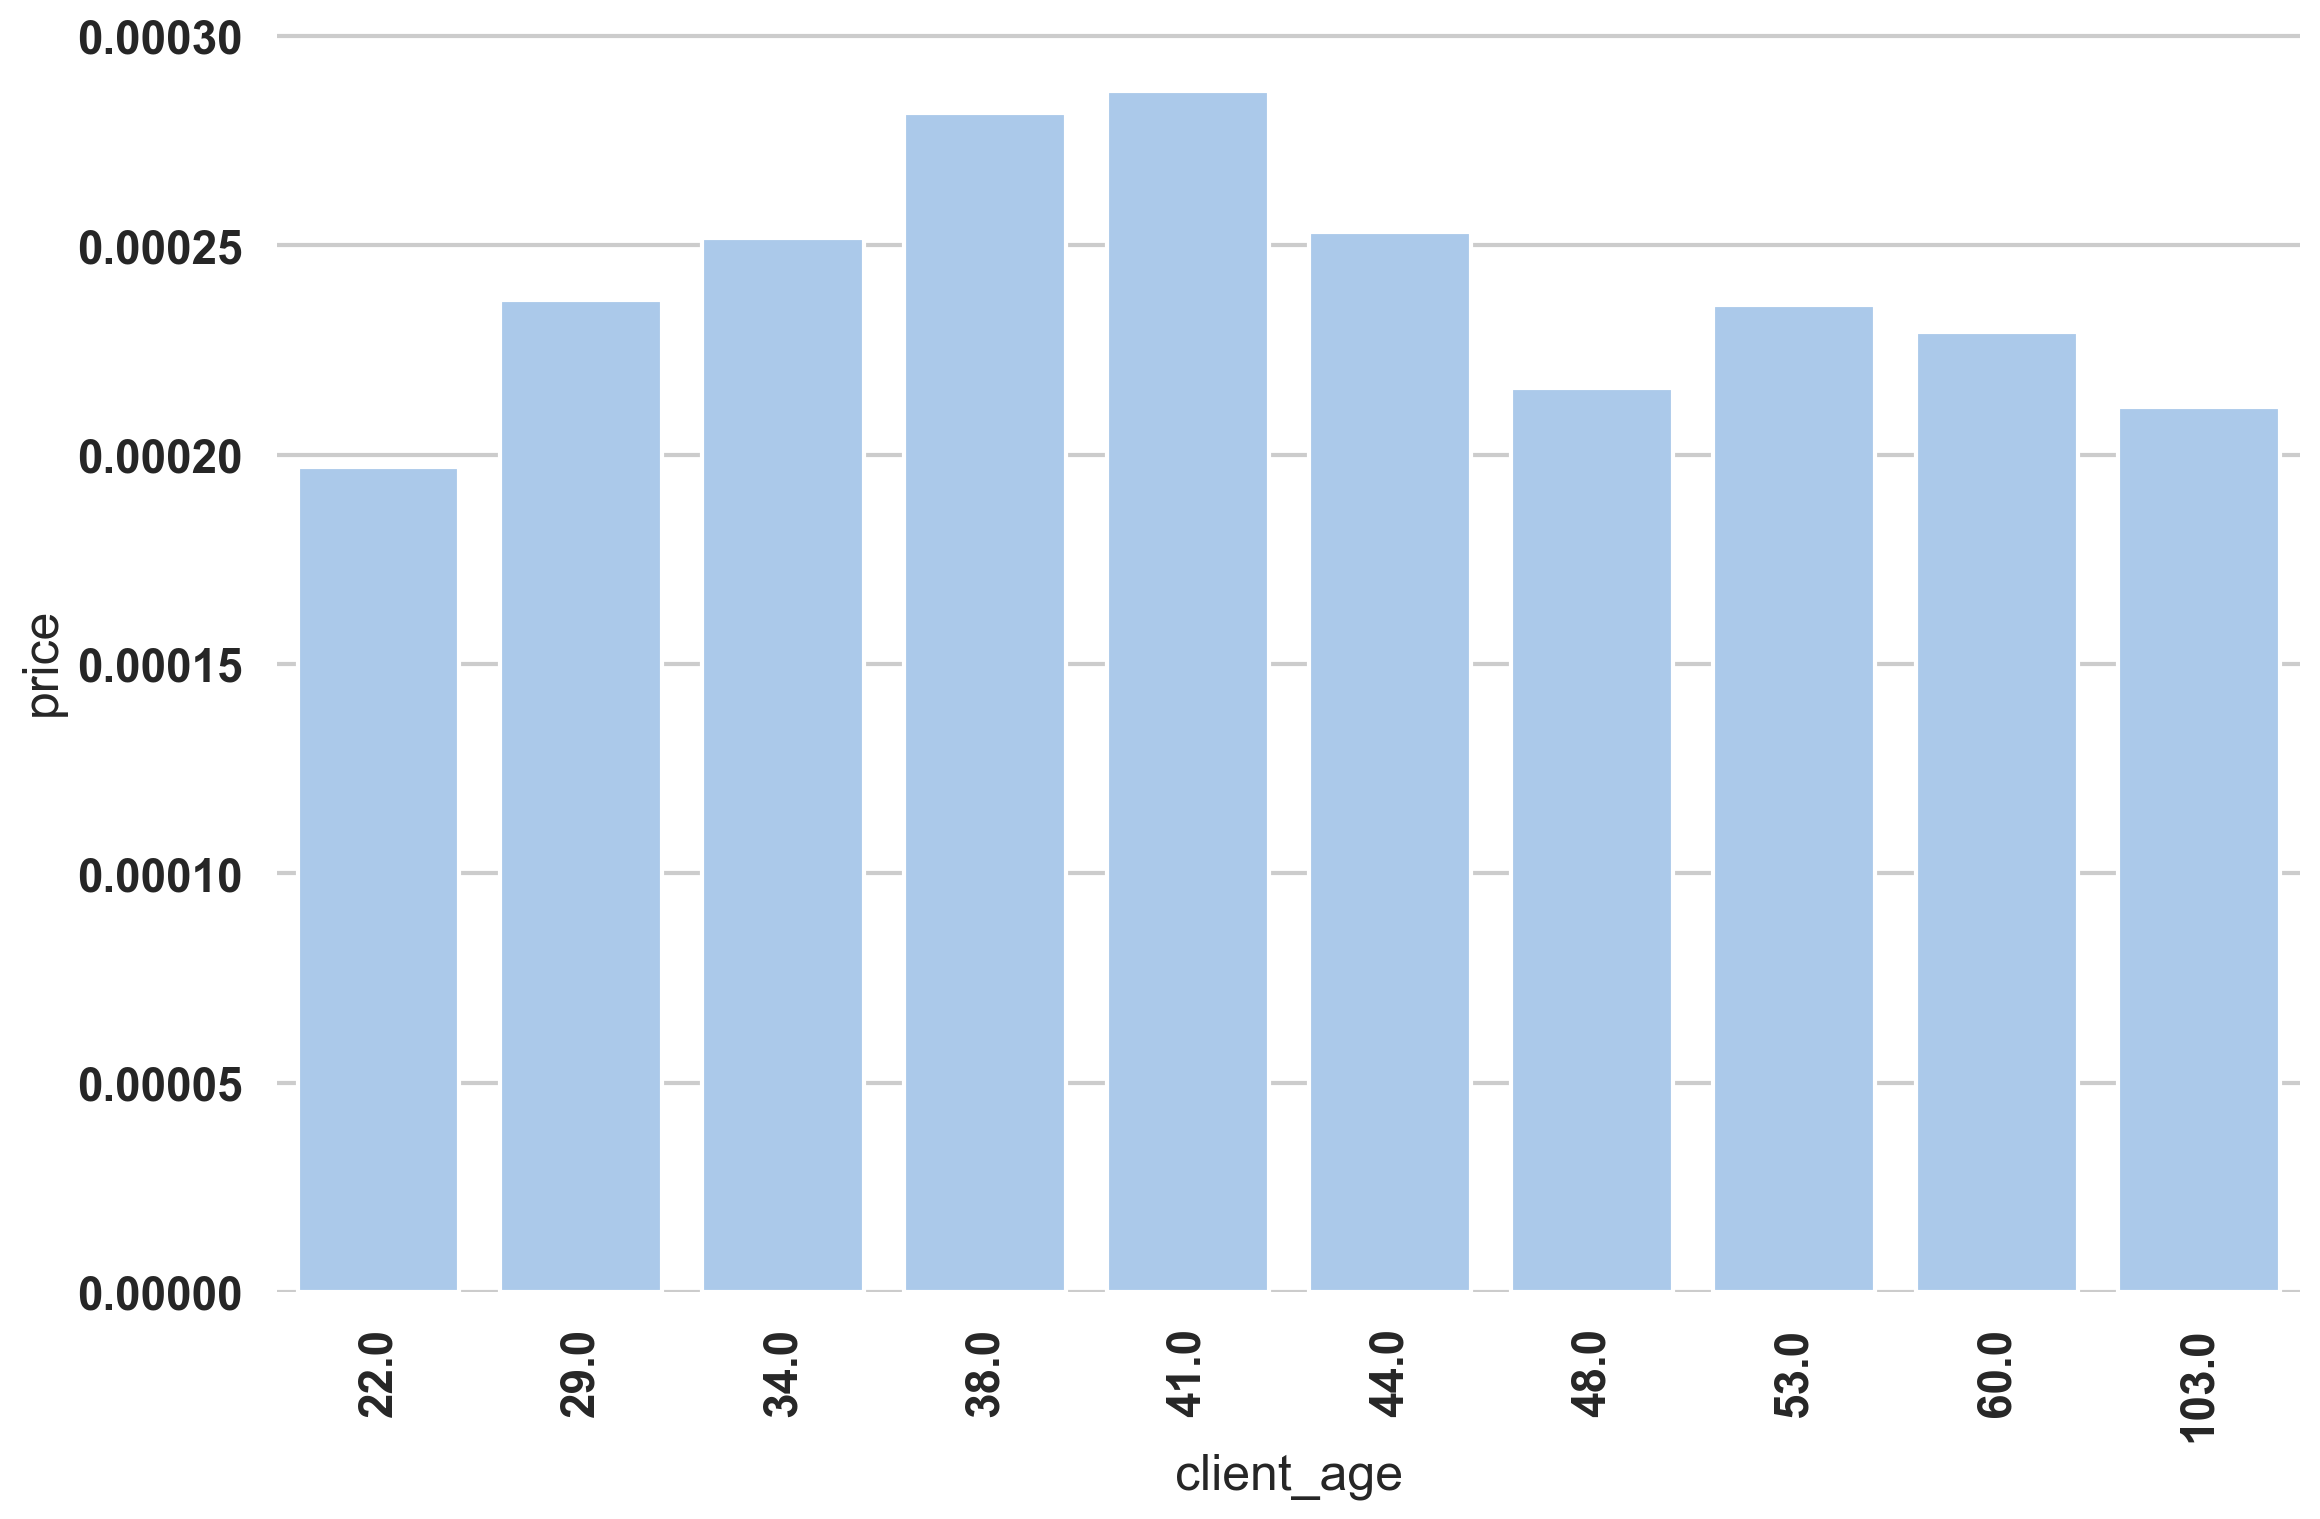

In [13]:
plt.figure()
ax = sns.barplot(x=df_age['client_age'], y=df_age['price'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

p-value: 0.0
Результаты проверки устойчивости по категориям:

employee_type:
  ГПД: p-value = 0.160000 
  ТК: p-value = 0.000000 ***
  ПКЦ: p-value = 0.183000 
  Прочие: недостаточно данных для анализа

employee_gender:
  Мужчина: p-value = 0.005000 **
  Женщина: p-value = 0.001000 **

client_gender:
  M: p-value = 0.000000 ***
  F: p-value = 0.010000 *
  nan: недостаточно данных для анализа

client_age_group:
  38.0: p-value = 0.013000 *
  22.0: p-value = 0.001000 **
  29.0: p-value = 0.007000 **
  41.0: p-value = 0.011000 *
  53.0: p-value = 0.310000 
  60.0: p-value = 0.525000 
  48.0: p-value = 0.398000 
  34.0: p-value = 0.466000 
  103.0: p-value = 0.882000 
  44.0: p-value = 0.053000 
  nan: недостаточно данных для анализа

Анализ для комбинаций переменных:

Комбинация: employee_type & employee_gender
  ('ГПД', 'Женщина'): p-value = 0.292000 
  ('ГПД', 'Мужчина'): p-value = 0.211000 
  ('ПКЦ', 'Женщина'): p-value = 0.303000 
  ('ПКЦ', 'Мужчина'): p-value = 0.296000 
  ('Прочие',

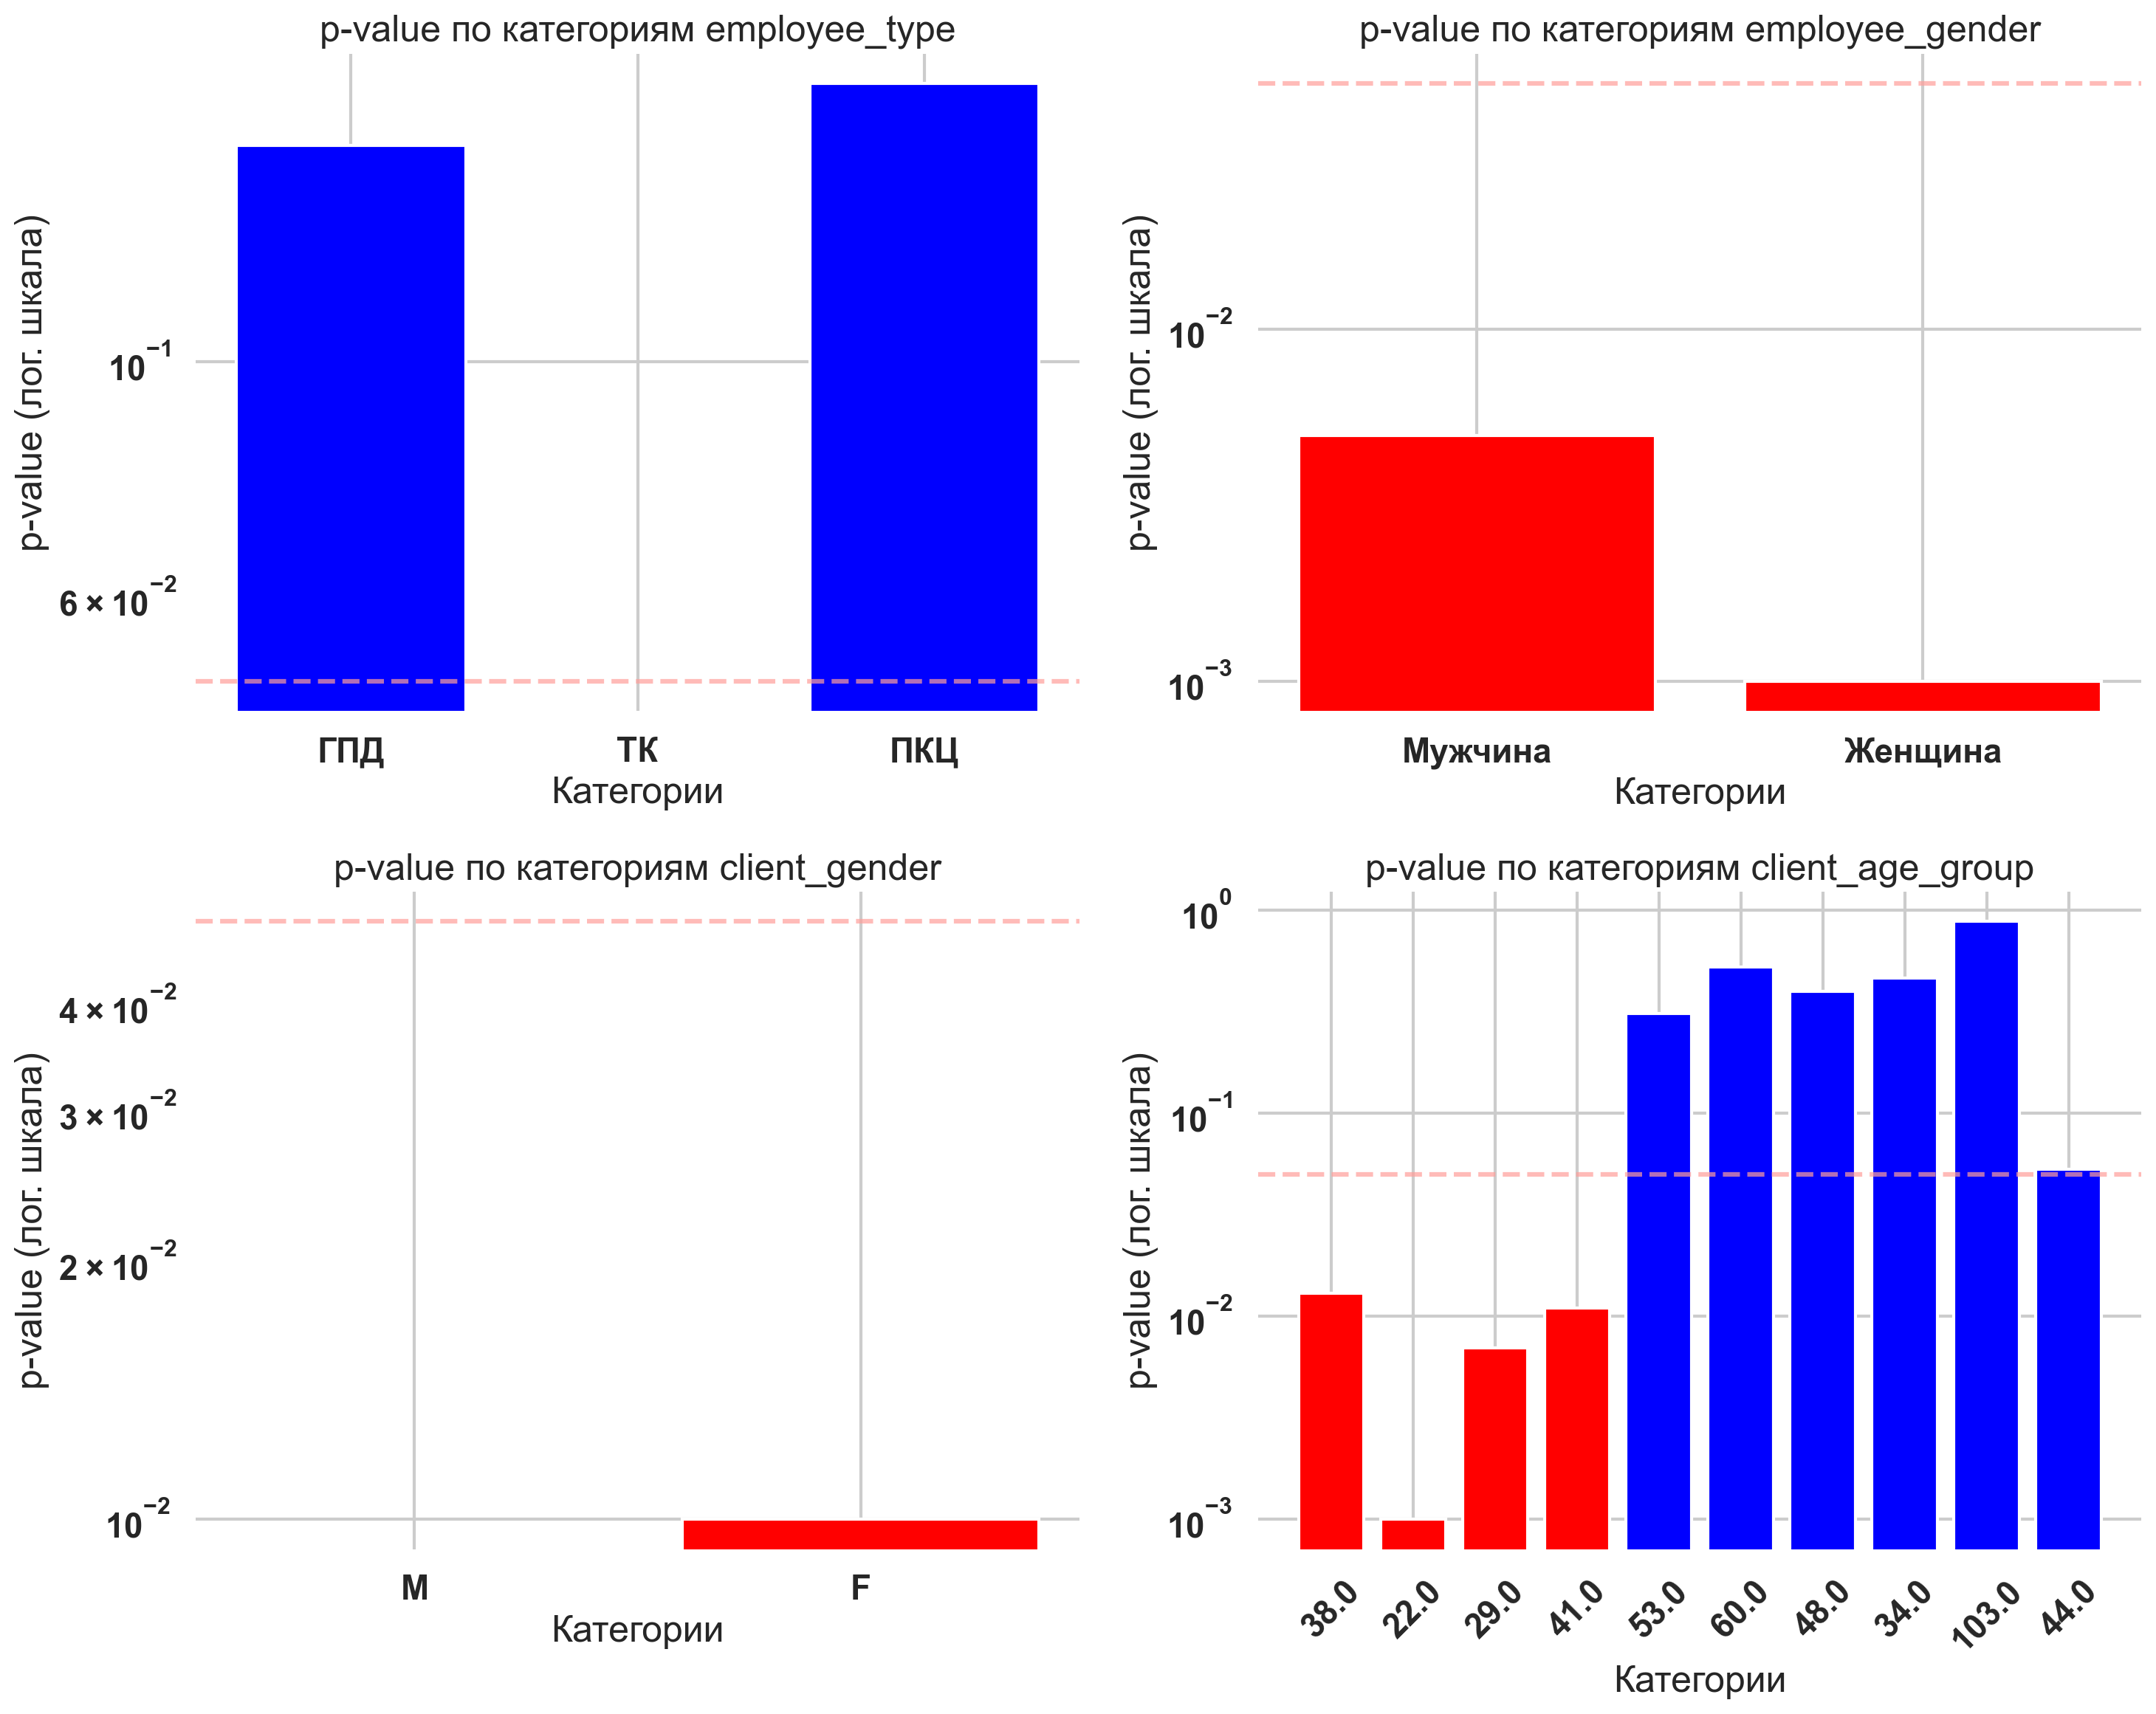

In [17]:
R_observed = []
gr = df.groupby('problem_status_code')
for name, group in gr:
    mean_b = group['application_flag'].mean()
    mean_c = group['employee_dialog_time_sec'].mean()
    R_observed.append(mean_b / mean_c)
T_observed = np.var(R_observed)

# Пермутационный тест
n_perm = 10000
T_permutations = []
for _ in range(n_perm):
    df_perm = df.copy()
    df_perm['problem_status_code'] = np.random.permutation(df['problem_status_code'])
    groups_perm = df_perm.groupby('problem_status_code')
    R_perm = []
    for name, group in groups_perm:
        mean_b_perm = group['application_flag'].mean()
        mean_c_perm = group['employee_dialog_time_sec'].mean()
        if mean_c_perm == 0:
            continue
        R_perm.append(mean_b_perm / mean_c_perm)
    if len(R_perm) > 0:
        T_permutations.append(np.var(R_perm))

p_value = np.mean(T_permutations >= T_observed)
print(f"p-value: {p_value}")

# Проверка устойчивости: стратифицированный анализ с выводом p-value для каждой категории
variables_to_check = ['employee_type', 'employee_gender', 'client_gender']

# Создание квантилей для client_age
age_quantiles = pd.qcut(df['client_age'], q=10, retbins=True)
age_bins = age_quantiles[1]
age_midpoints = [age_bins[i+1] for i in range(len(age_bins)-1)]

# Создание новой переменной с серединами отрезков
df['client_age_group'] = pd.qcut(df['client_age'], q=10, labels=age_midpoints)
variables_to_check.append('client_age_group')  # Добавляем в список переменных для проверки

# Функция для проведения пермутационного теста на подмножестве данных
def run_permutation_test_on_subset(subset, n_perm=1000):
    if len(subset) < 30:  # Минимальный размер выборки для теста
        return np.nan
    
    gr = subset.groupby('problem_status_code')
    R_observed = []
    for name, group in gr:
        mean_b = group['application_flag'].mean()
        mean_c = group['employee_dialog_time_sec'].mean()
        if mean_c != 0:
            R_observed.append(mean_b / mean_c)
    
    if len(R_observed) < 2:  # Нужно как минимум две группы для дисперсии
        return np.nan
    
    T_observed = np.var(R_observed)
    
    T_permutations = []
    for _ in range(n_perm):
        subset_perm = subset.copy()
        subset_perm['problem_status_code'] = np.random.permutation(subset['problem_status_code'])
        groups_perm = subset_perm.groupby('problem_status_code')
        R_perm = []
        for name, group in groups_perm:
            mean_b_perm = group['application_flag'].mean()
            mean_c_perm = group['employee_dialog_time_sec'].mean()
            if mean_c_perm != 0:
                R_perm.append(mean_b_perm / mean_c_perm)
        if len(R_perm) > 1:
            T_permutations.append(np.var(R_perm))
    
    if len(T_permutations) == 0:
        return np.nan
    
    p_value = np.mean(T_permutations >= T_observed)
    return p_value

# Проведение анализа для каждой переменной и каждой категории
results = {}
for var in variables_to_check:
    results[var] = {}
    for category in df[var].unique():
        subset = df[df[var] == category]
        p_val = run_permutation_test_on_subset(subset)
        results[var][category] = p_val

# Вывод результатов для каждой категории
print("Результаты проверки устойчивости по категориям:")
for var in variables_to_check:
    print(f"\n{var}:")
    for category, p_val in results[var].items():
        if not np.isnan(p_val):
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"  {category}: p-value = {p_val:.6f} {significance}")
        else:
            print(f"  {category}: недостаточно данных для анализа")

# Дополнительно: анализ для комбинаций переменных
print("\nАнализ для комбинаций переменных:")
important_combinations = [
    ['employee_type', 'employee_gender'],
    ['employee_type', 'client_gender'],
    ['employee_gender', 'client_gender']
]

for combo in important_combinations:
    print(f"\nКомбинация: {' & '.join(combo)}")
    groups = df.groupby(combo)
    
    for name, group in groups:
        p_val = run_permutation_test_on_subset(group)
        if not np.isnan(p_val):
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"  {name}: p-value = {p_val:.6f} {significance}")
        else:
            print(f"  {name}: недостаточно данных для анализа")

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, var in enumerate(variables_to_check):
    categories = []
    p_values = []
    
    for category, p_val in results[var].items():
        if not np.isnan(p_val):
            categories.append(str(category))
            p_values.append(p_val)
    
    if categories:
        axes[i].bar(categories, p_values, color=['red' if p < 0.05 else 'blue' for p in p_values])
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_yscale('log')
        axes[i].set_xlabel('Категории')
        axes[i].set_ylabel('p-value (лог. шкала)')
        axes[i].set_title(f'p-value по категориям {var}')
        
        # Для возраста поворачиваем подписи для лучшей читаемости
        if var == 'client_age_group':
            axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

t-test p-value: 0.000010
Результаты проверки устойчивости по категориям:

employee_type:
  ГПД: p-value = 0.120220 
  ТК: p-value = 0.000013 ***
  ПКЦ: p-value = 0.362054 
  Прочие: недостаточно данных для анализа

employee_gender:
  Мужчина: p-value = 0.001542 **
  Женщина: p-value = 0.001280 **

client_gender:
  M: p-value = 0.000624 ***
  F: p-value = 0.002604 **
  nan: недостаточно данных для анализа

client_age_group:
  38.0: p-value = 0.023492 *
  22.0: p-value = 0.000586 ***
  29.0: p-value = 0.010087 *
  41.0: p-value = 0.010653 *
  53.0: p-value = 0.294593 
  60.0: p-value = 0.766234 
  48.0: p-value = 0.584885 
  34.0: p-value = 0.348302 
  79.0: p-value = 0.732455 
  44.0: p-value = 0.103034 

Анализ для комбинаций переменных:

Комбинация: employee_type & employee_gender
  ('ГПД', 'Женщина'): p-value = 0.208489 
  ('ГПД', 'Мужчина'): p-value = 0.201669 
  ('ПКЦ', 'Женщина'): p-value = 0.565427 
  ('ПКЦ', 'Мужчина'): p-value = 0.338117 
  ('Прочие', 'Женщина'): недостаточно д

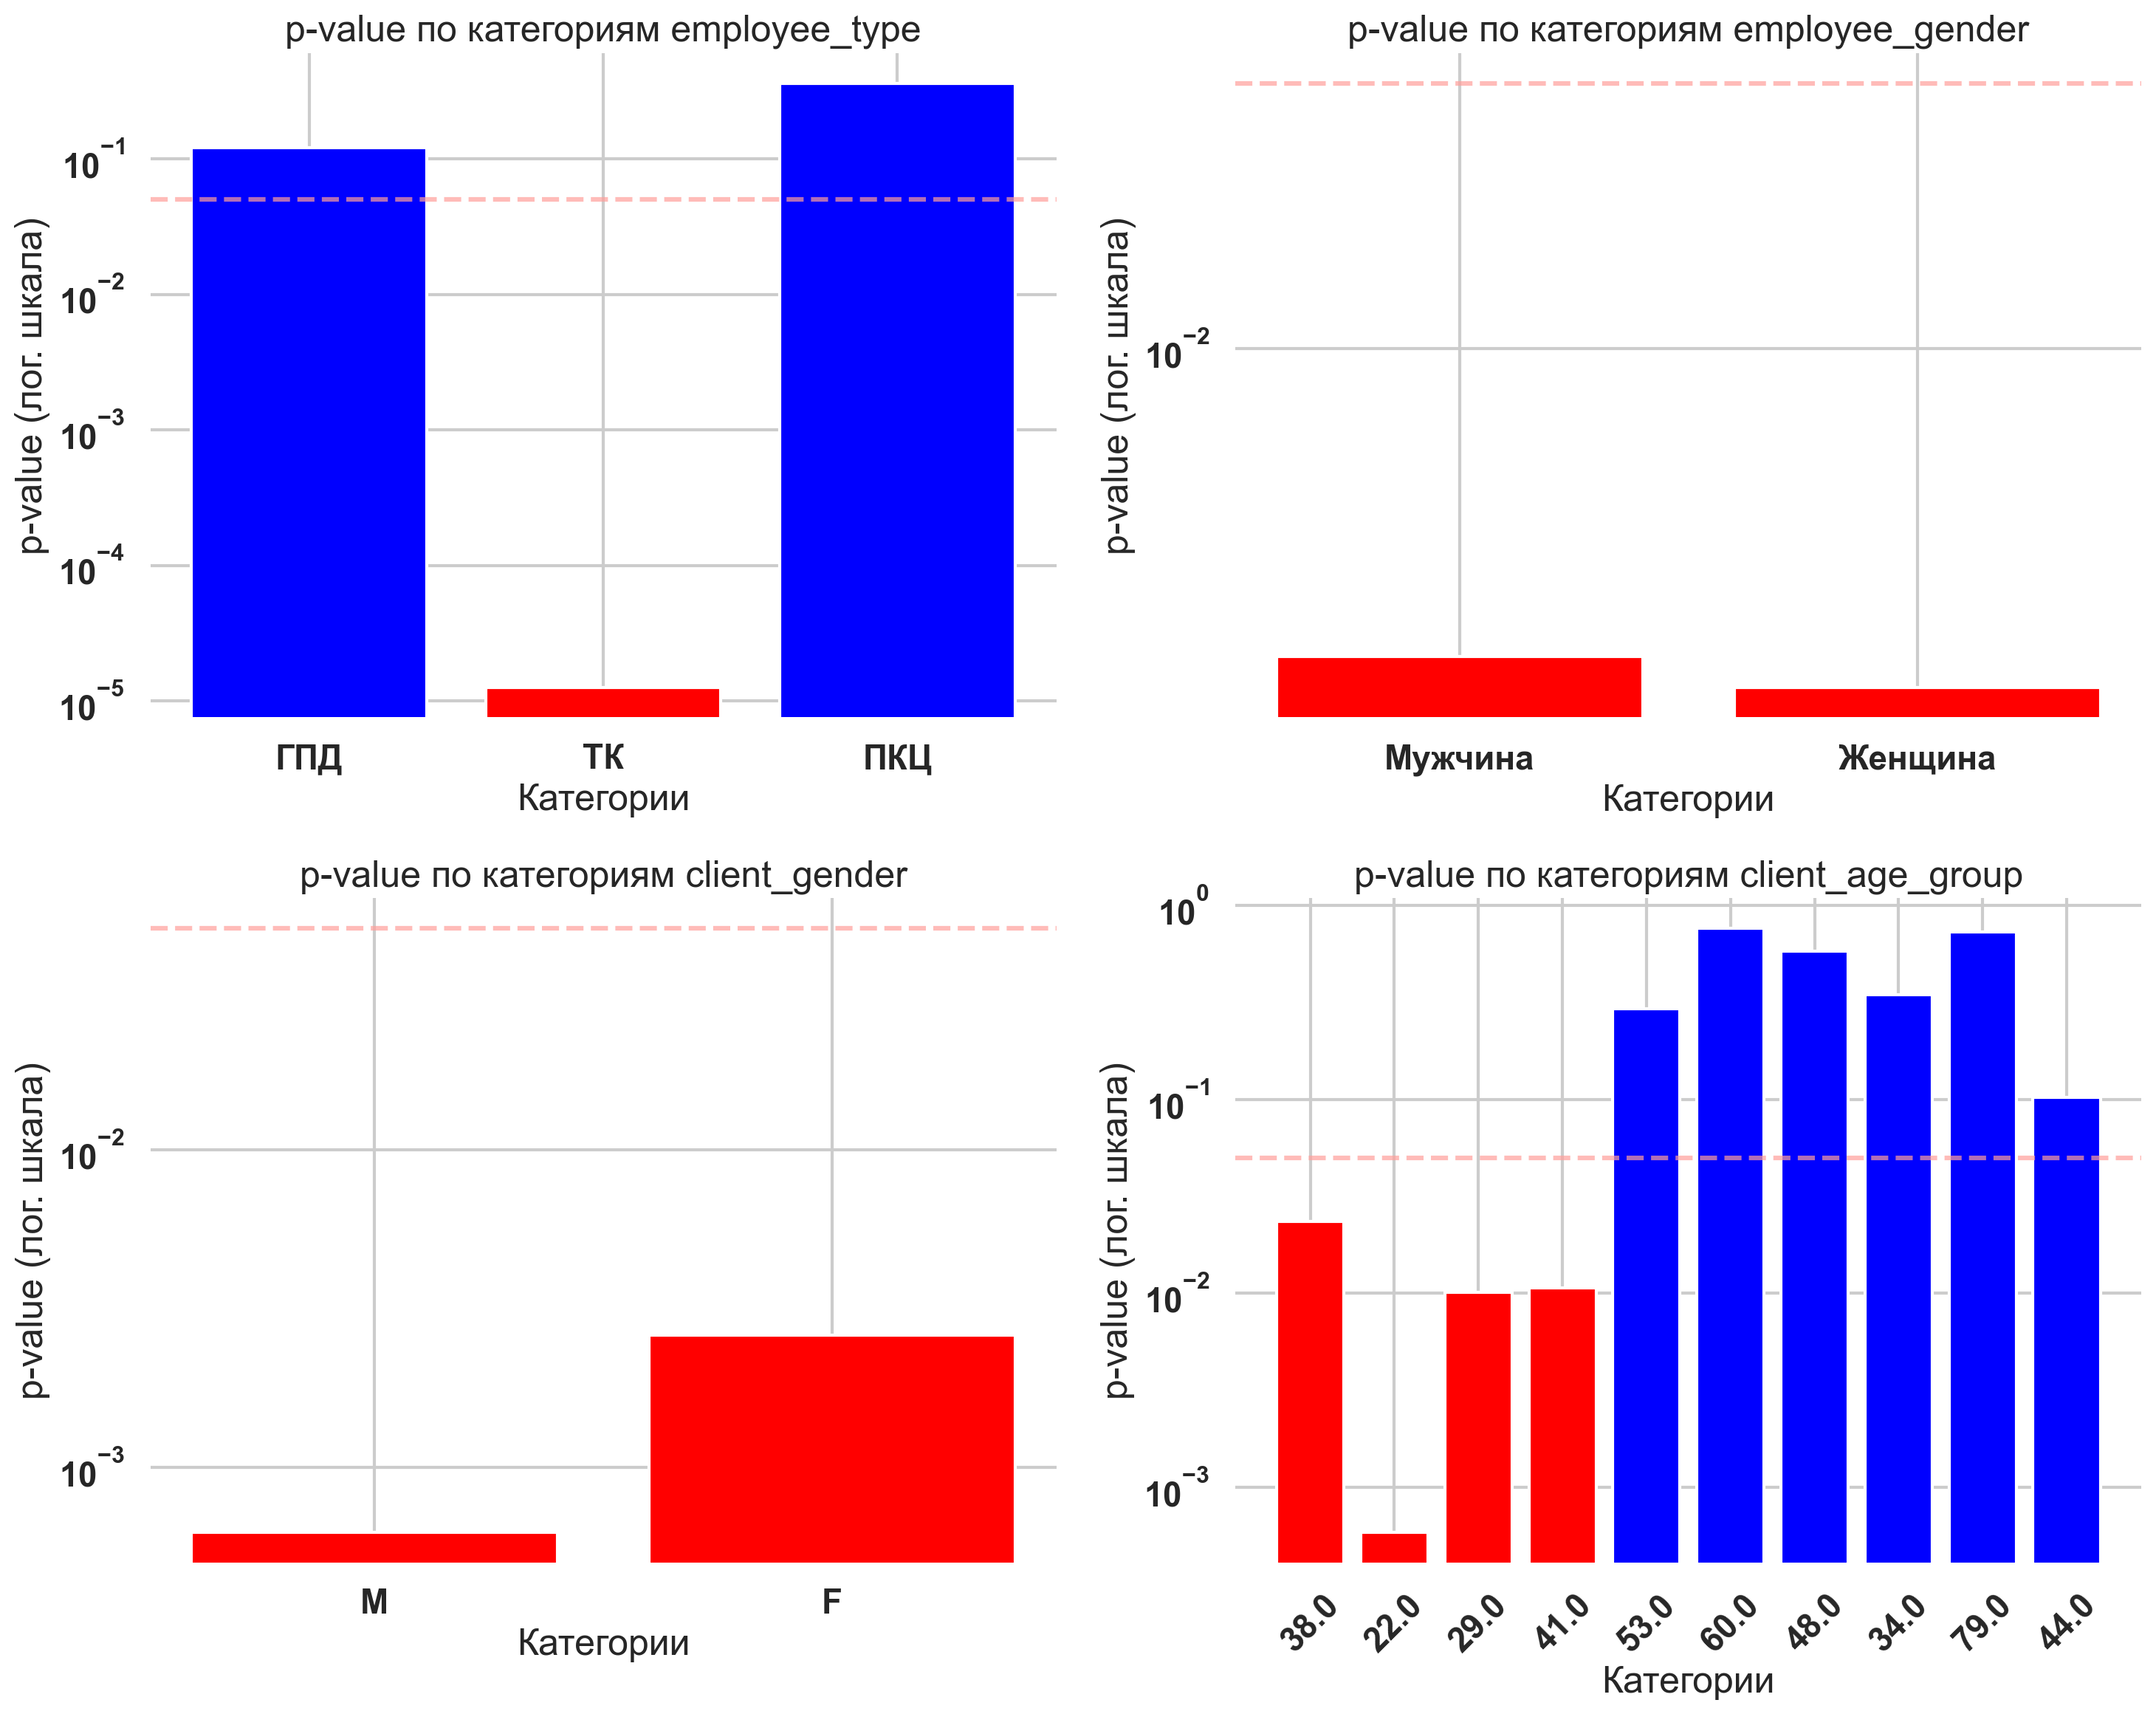

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind

# Основной тест для всей выборки
groups = [group['application_flag'].values for name, group in df.groupby('problem_status_code')]
if len(groups) == 2:
    t_stat, p_value = ttest_ind(groups[0], groups[1])
    print(f"t-test p-value: {p_value:.6f}")
elif len(groups) > 2:
    f_stat, p_value = f_oneway(*groups)
    print(f"ANOVA p-value: {p_value:.6f}")
else:
    print("Недостаточно групп для теста")

# Проверка устойчивости: стратифицированный анализ с выводом p-value для каждой категории
variables_to_check = ['employee_type', 'employee_gender', 'client_gender']

# Создание квантилей для client_age
age_quantiles = pd.qcut(df['client_age'], q=10, retbins=True)
age_bins = age_quantiles[1]
age_midpoints = [age_bins[i+1] for i in range(len(age_bins)-1)]

# Создание новой переменной с серединами отрезков
df['client_age_group'] = pd.qcut(df['client_age'], q=10, labels=age_midpoints)
variables_to_check.append('client_age_group')  # Добавляем в список переменных для проверки

# Функция для проведения теста на подмножестве данных
def run_statistical_test(subset):
    if len(subset) < 30:  # Минимальный размер выборки для теста
        return np.nan
    
    groups = [group['application_flag'].values for name, group in subset.groupby('problem_status_code')]
    n_groups = len(groups)
    
    if n_groups < 2:  # Нужно как минимум две группы для теста
        return np.nan
    
    if n_groups == 2:
        t_stat, p_value = ttest_ind(groups[0], groups[1])
        return p_value
    else:
        try:
            f_stat, p_value = f_oneway(*groups)
            return p_value
        except:
            return np.nan

# Проведение анализа для каждой переменной и каждой категории
results = {}
for var in variables_to_check:
    results[var] = {}
    for category in df[var].unique():
        subset = df[df[var] == category]
        p_val = run_statistical_test(subset)
        results[var][category] = p_val

# Вывод результатов для каждой категории
print("Результаты проверки устойчивости по категориям:")
for var in variables_to_check:
    print(f"\n{var}:")
    for category, p_val in results[var].items():
        if not np.isnan(p_val):
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"  {category}: p-value = {p_val:.6f} {significance}")
        else:
            print(f"  {category}: недостаточно данных для анализа")

# Дополнительно: анализ для комбинаций переменных
print("\nАнализ для комбинаций переменных:")
important_combinations = [
    ['employee_type', 'employee_gender'],
    ['employee_type', 'client_gender'],
    ['employee_gender', 'client_gender']
]

for combo in important_combinations:
    print(f"\nКомбинация: {' & '.join(combo)}")
    groups = df.groupby(combo)
    
    for name, group in groups:
        p_val = run_statistical_test(group)
        if not np.isnan(p_val):
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"  {name}: p-value = {p_val:.6f} {significance}")
        else:
            print(f"  {name}: недостаточно данных для анализа")

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, var in enumerate(variables_to_check):
    categories = []
    p_values = []
    
    for category, p_val in results[var].items():
        if not np.isnan(p_val):
            categories.append(str(category))
            p_values.append(p_val)
    
    if categories:
        axes[i].bar(categories, p_values, color=['red' if p < 0.05 else 'blue' for p in p_values])
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_yscale('log')
        axes[i].set_xlabel('Категории')
        axes[i].set_ylabel('p-value (лог. шкала)')
        axes[i].set_title(f'p-value по категориям {var}')
        
        # Для возраста поворачиваем подписи для лучшей читаемости
        if var == 'client_age_group':
            axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

t-test p-value (Levene's p=0.000010): 0.000011
Результаты проверки устойчивости по категориям:

employee_type:
  ГПД: p-value = 0.120220 
  ТК: p-value = 0.000015 ***
  ПКЦ: p-value = 0.362054 
  Прочие: недостаточно данных для анализа

employee_gender:
  Мужчина: p-value = 0.001658 **
  Женщина: p-value = 0.001378 **

client_gender:
  M: p-value = 0.000685 ***
  F: p-value = 0.002770 **
  nan: недостаточно данных для анализа

client_age_group:
  38.0: p-value = 0.025449 *
  22.0: p-value = 0.000900 ***
  29.0: p-value = 0.011946 *
  41.0: p-value = 0.011495 *
  53.0: p-value = 0.294593 
  60.0: p-value = 0.766234 
  48.0: p-value = 0.584885 
  34.0: p-value = 0.348302 
  79.0: p-value = 0.732455 
  44.0: p-value = 0.103034 

Анализ для комбинаций переменных:

Комбинация: employee_type & employee_gender
  ('ГПД', 'Женщина'): p-value = 0.208489 
  ('ГПД', 'Мужчина'): p-value = 0.201669 
  ('ПКЦ', 'Женщина'): p-value = 0.565427 
  ('ПКЦ', 'Мужчина'): p-value = 0.338117 
  ('Прочие', 'Жен

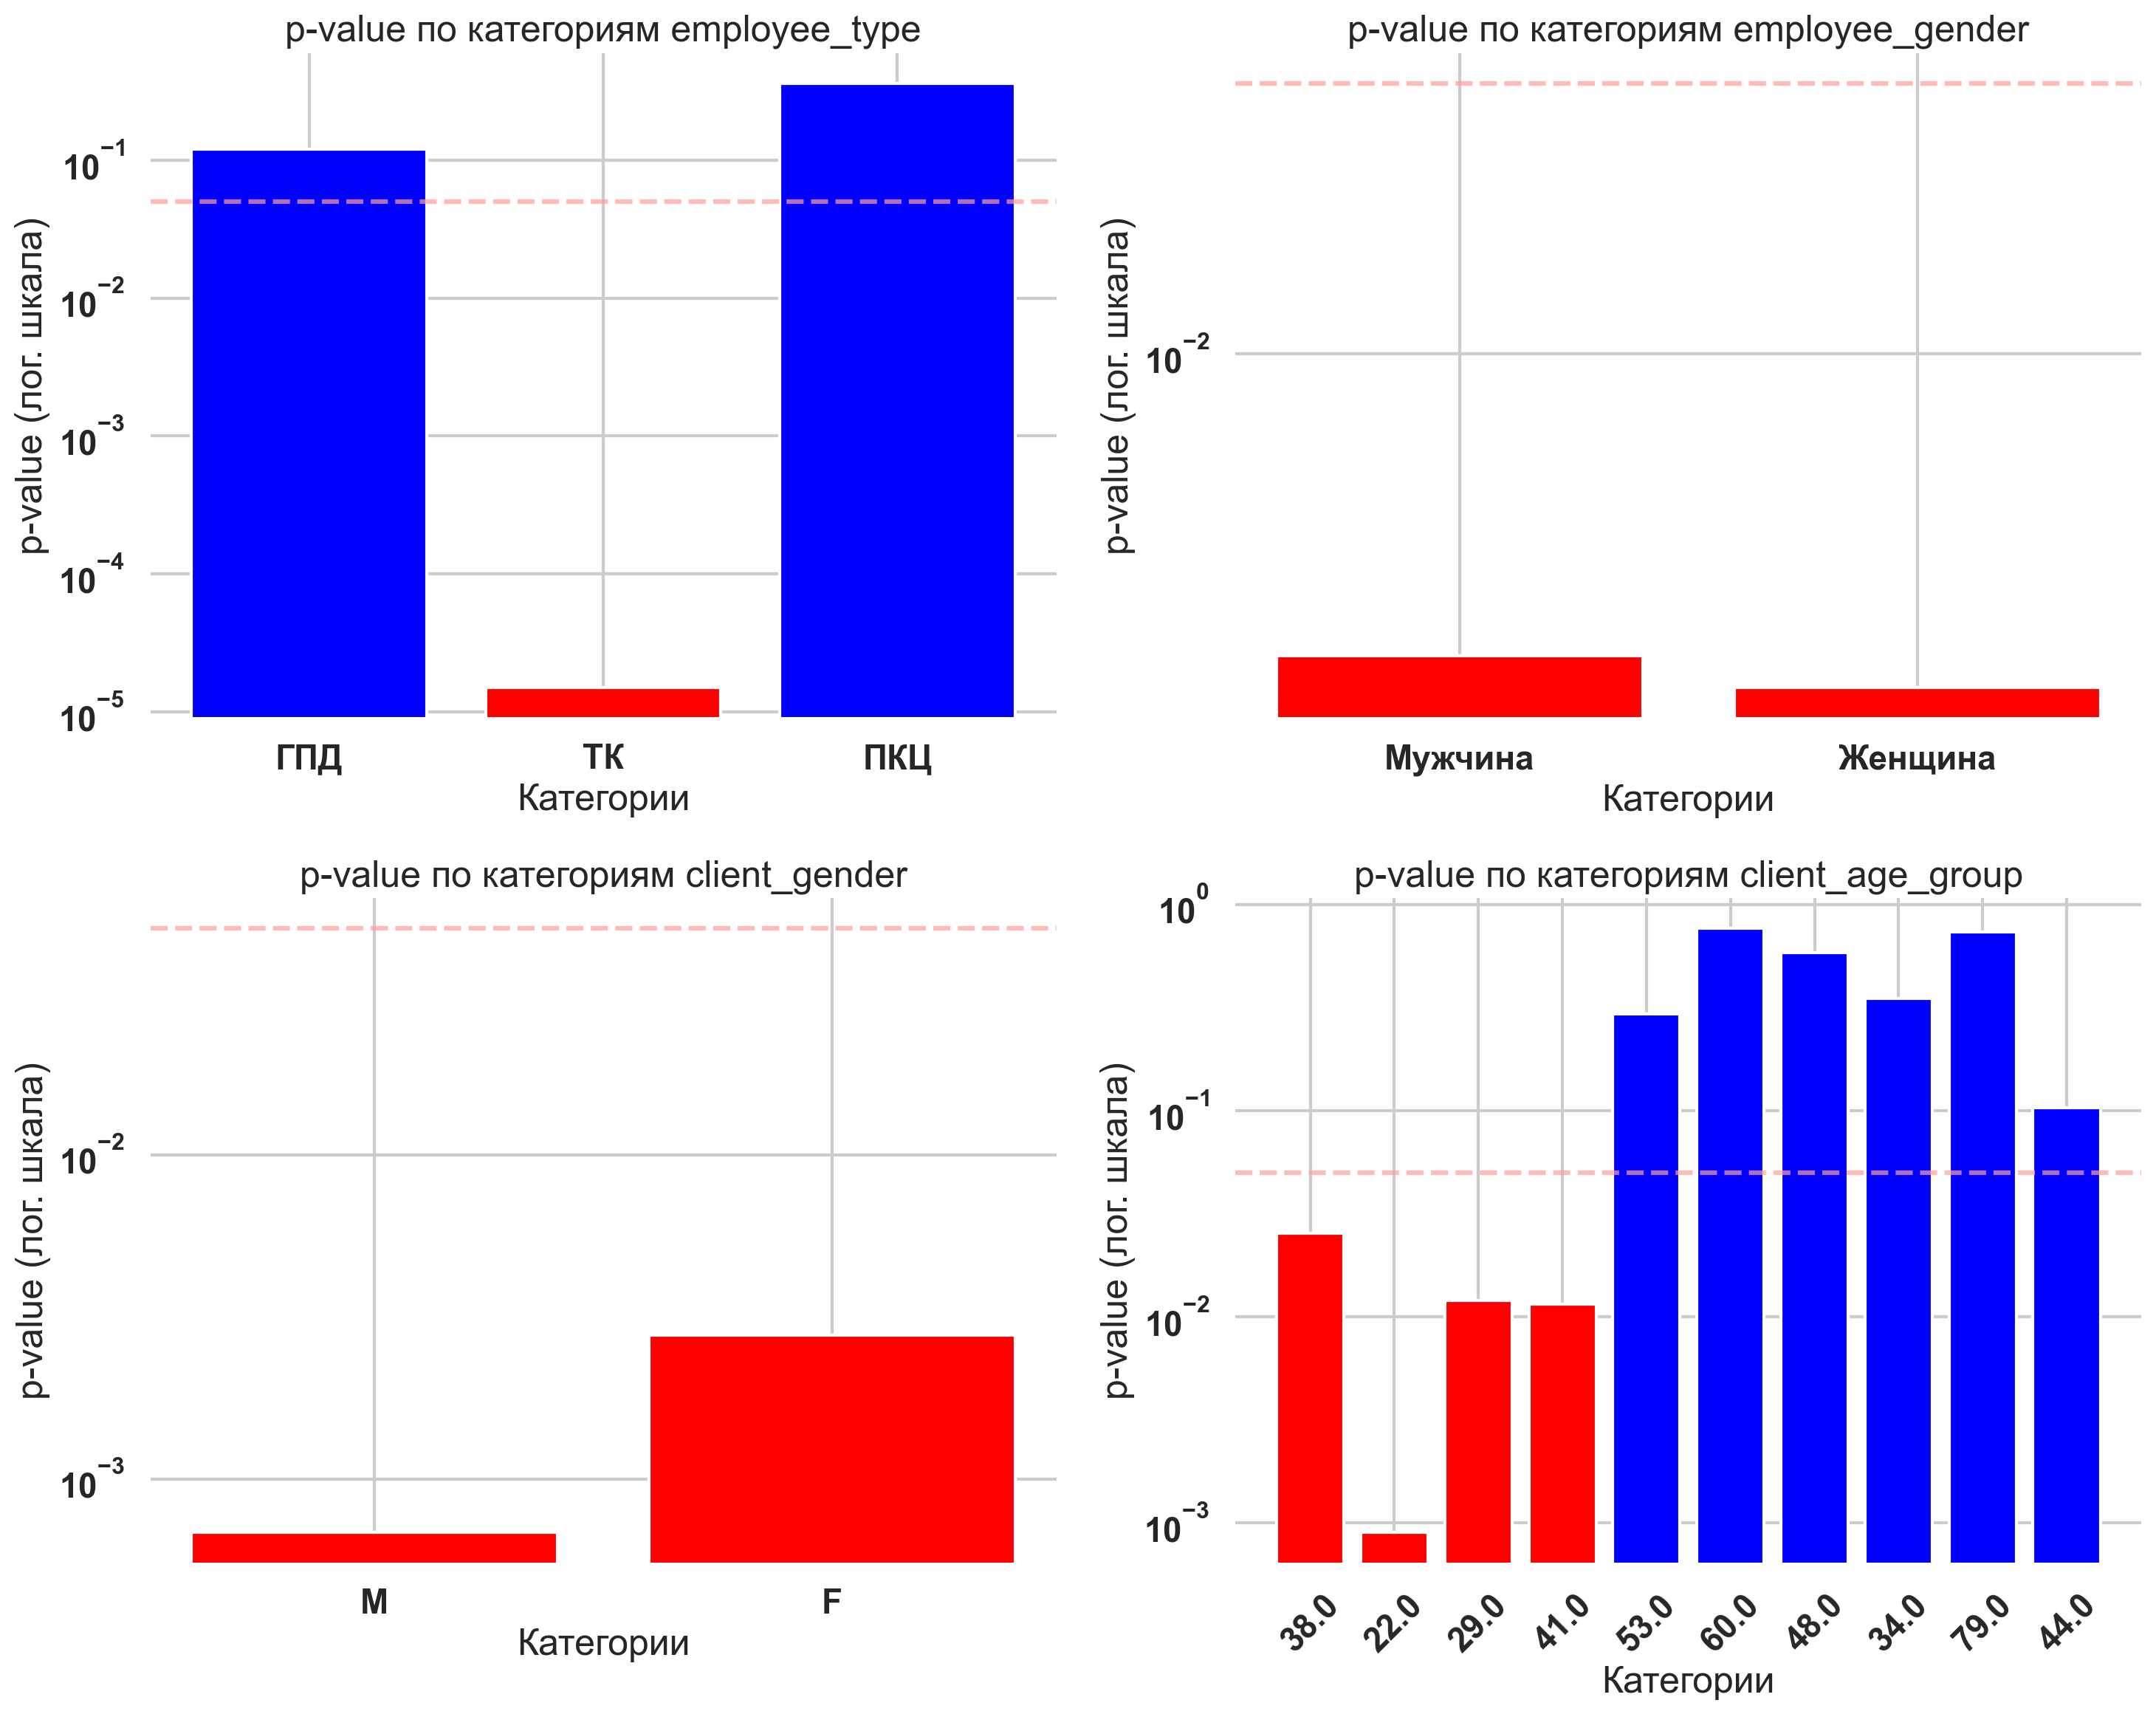

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import levene, ttest_ind  # Удален f_oneway, добавлен levene

# Основной тест для всей выборки
groups = [group['application_flag'].values for name, group in df.groupby('problem_status_code')]
if len(groups) == 2:
    levene_stat, levene_p = levene(groups[0], groups[1])
    if levene_p > 0.05:
        t_stat, p_value = ttest_ind(groups[0], groups[1], equal_var=True)
    else:
        t_stat, p_value = ttest_ind(groups[0], groups[1], equal_var=False)
    print(f"t-test p-value (Levene's p={levene_p:.6f}): {p_value:.6f}")
elif len(groups) > 2:
    print("More than two groups detected. ANOVA is removed. Please check pairwise comparisons using t-tests with Levene's test.")
else:
    print("Недостаточно групп для теста")

# Проверка устойчивости: стратифицированный анализ с выводом p-value для каждой категории
variables_to_check = ['employee_type', 'employee_gender', 'client_gender']

# Создание квантилей для client_age
age_quantiles = pd.qcut(df['client_age'], q=10, retbins=True)
age_bins = age_quantiles[1]
age_midpoints = [age_bins[i+1] for i in range(len(age_bins)-1)]

# Создание новой переменной с серединами отрезков
df['client_age_group'] = pd.qcut(df['client_age'], q=10, labels=age_midpoints)
variables_to_check.append('client_age_group')  # Добавляем в список переменных для проверки

# Функция для проведения теста на подмножестве данных
def run_statistical_test(subset):
    if len(subset) < 30:  # Минимальный размер выборки для теста
        return np.nan
    
    groups = [group['application_flag'].values for name, group in subset.groupby('problem_status_code')]
    n_groups = len(groups)
    
    if n_groups < 2:  # Нужно как минимум две группы для теста
        return np.nan
    
    if n_groups == 2:
        levene_stat, levene_p = levene(groups[0], groups[1])
        if levene_p > 0.05:
            t_stat, p_value = ttest_ind(groups[0], groups[1], equal_var=True)
        else:
            t_stat, p_value = ttest_ind(groups[0], groups[1], equal_var=False)
        return p_value
    else:
        # Для более чем двух групп ANOVA удалён - возвращаем NaN
        return np.nan

# Проведение анализа для каждой переменной и каждой категории
results = {}
for var in variables_to_check:
    results[var] = {}
    for category in df[var].unique():
        subset = df[df[var] == category]
        p_val = run_statistical_test(subset)
        results[var][category] = p_val

# Вывод результатов для каждой категории
print("Результаты проверки устойчивости по категориям:")
for var in variables_to_check:
    print(f"\n{var}:")
    for category, p_val in results[var].items():
        if not np.isnan(p_val):
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"  {category}: p-value = {p_val:.6f} {significance}")
        else:
            print(f"  {category}: недостаточно данных для анализа")

# Дополнительно: анализ для комбинаций переменных
print("\nАнализ для комбинаций переменных:")
important_combinations = [
    ['employee_type', 'employee_gender'],
    ['employee_type', 'client_gender'],
    ['employee_gender', 'client_gender']
]

for combo in important_combinations:
    print(f"\nКомбинация: {' & '.join(combo)}")
    groups = df.groupby(combo)
    
    for name, group in groups:
        p_val = run_statistical_test(group)
        if not np.isnan(p_val):
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"  {name}: p-value = {p_val:.6f} {significance}")
        else:
            print(f"  {name}: недостаточно данных для анализа")

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, var in enumerate(variables_to_check):
    categories = []
    p_values = []
    
    for category, p_val in results[var].items():
        if not np.isnan(p_val):
            categories.append(str(category))
            p_values.append(p_val)
    
    if categories:
        axes[i].bar(categories, p_values, color=['red' if p < 0.05 else 'blue' for p in p_values])
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_yscale('log')
        axes[i].set_xlabel('Категории')
        axes[i].set_ylabel('p-value (лог. шкала)')
        axes[i].set_title(f'p-value по категориям {var}')
        
        # Для возраста поворачиваем подписи для лучшей читаемости
        if var == 'client_age_group':
            axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
import numpy as np

# Предположим, у нас есть DataFrame df с колонкой 'client_age'
# Сначала вычислим квартили и IQR
Q1 = df['client_age'].quantile(0.25)
Q3 = df['client_age'].quantile(0.75)
IQR = Q3 - Q1

# Определим границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удалим выбросы
df = df[(df['client_age'] >= lower_bound) & (df['client_age'] <= upper_bound)]

In [20]:
df.columns

Index(['call_id', 'client_id', 'employee_id', 'offer_type', 'offer_time_sec',
       'voice_offer_flag', 'application_flag', 'utilization_flag',
       'utilization_dt', 'client_agree_flg', 'wait_time_sec',
       'appeal_time_sec', 'employee_dialog_time_sec', 'repeated_appeal_flg',
       'negative_flg', 'call_dttm', 'csat_score', 'transfer_flg', 'task_flg',
       'problem_status_code', 'client_age', 'client_gender',
       'client_education', 'сlient_city', 'marital_status_cd', 'children_cnt',
       'foreign_flg', 'suppress_call_flg', 'suppress_email_flg',
       'suppress_limit_flg', 'suppress_sms_flg', 'work_experience_day_cnt',
       'employee_type', 'employee_city', 'employee_gender', 'business_line',
       'client_age_group', 'age_bin'],
      dtype='object')

In [31]:
df.isna().sum()

call_id                         0
client_id                       0
employee_id                     0
offer_type                      0
offer_time_sec                293
voice_offer_flag                0
application_flag                0
utilization_flag                0
utilization_dt              22892
client_agree_flg             1670
wait_time_sec                   0
appeal_time_sec                 0
employee_dialog_time_sec        0
repeated_appeal_flg             0
negative_flg                    0
call_dttm                       0
csat_score                  19731
transfer_flg                    0
task_flg                        0
problem_status_code             0
client_age                      0
client_gender                 119
client_education            12551
сlient_city                 10177
marital_status_cd            9691
children_cnt                 8853
foreign_flg                     0
suppress_call_flg             690
suppress_email_flg            690
suppress_limit

In [43]:
from catboost import CatBoostClassifier

df.dropna()

# Подготовка данных
X = df[['wait_time_sec', 'appeal_time_sec', 'offer_type', 'work_experience_day_cnt', 'employee_type', 'client_age', 'task_flg', 'negative_flg', 'problem_status_code', 'business_line']]
y = df['application_flag']

# Определяем категориальные признаки
cat_features = ['offer_type', 'employee_type', 'problem_status_code', 'business_line']

# Обучаем модель
model = CatBoostClassifier(verbose=2, random_state=52, iterations=500, depth=4, l2_leaf_reg=4)
model.fit(X, y, cat_features=cat_features)

0:	learn: 0.6624900	total: 22.6ms	remaining: 11.3s
2:	learn: 0.6069813	total: 57.2ms	remaining: 9.47s
4:	learn: 0.5617383	total: 85.3ms	remaining: 8.44s
6:	learn: 0.5220812	total: 102ms	remaining: 7.15s
8:	learn: 0.4882051	total: 113ms	remaining: 6.14s
10:	learn: 0.4599428	total: 122ms	remaining: 5.43s
12:	learn: 0.4353447	total: 133ms	remaining: 4.99s
14:	learn: 0.4149456	total: 143ms	remaining: 4.63s
16:	learn: 0.3971949	total: 154ms	remaining: 4.37s
18:	learn: 0.3816155	total: 164ms	remaining: 4.14s
20:	learn: 0.3687360	total: 175ms	remaining: 3.99s
22:	learn: 0.3569663	total: 185ms	remaining: 3.84s
24:	learn: 0.3467804	total: 195ms	remaining: 3.7s
26:	learn: 0.3381228	total: 205ms	remaining: 3.59s
28:	learn: 0.3306530	total: 216ms	remaining: 3.5s
30:	learn: 0.3235812	total: 225ms	remaining: 3.4s
32:	learn: 0.3178655	total: 236ms	remaining: 3.33s
34:	learn: 0.3119998	total: 245ms	remaining: 3.26s
36:	learn: 0.3062206	total: 255ms	remaining: 3.19s
38:	learn: 0.3008883	total: 266ms	re

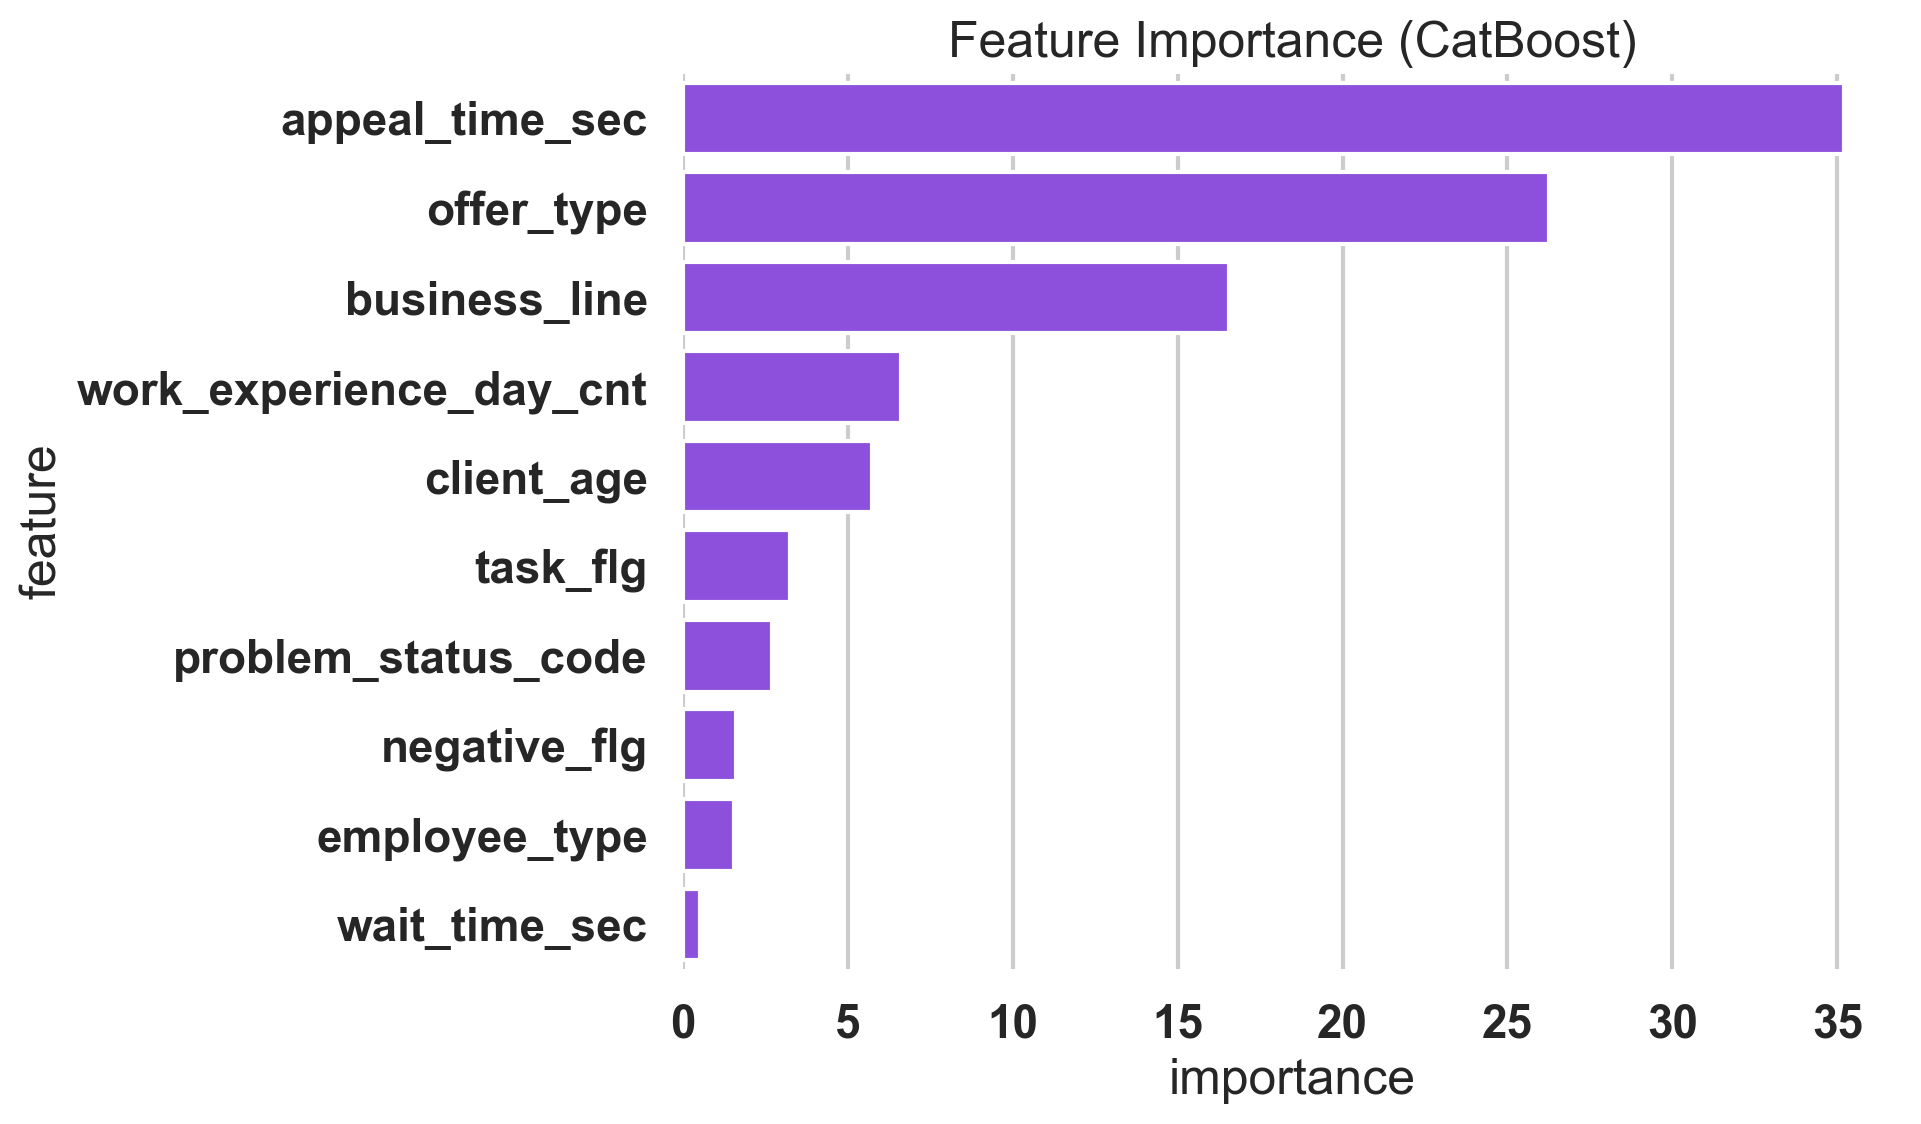

In [44]:
# Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, color="#8A38F5")
plt.title('Feature Importance (CatBoost)')
plt.tight_layout()
plt.show()

In [15]:
plt.figure()
ax = sns.barplot(x=df_age['client_age'], y=df_age['problem_status_code'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

KeyError: 'problem_status_code'

<Figure size 1200x800 with 0 Axes>

In [ ]:
df['employee_type'].value_counts()

employee_type
ТК        14136
ГПД        6352
ПКЦ        3592
Прочие       12
Name: count, dtype: int64

<Axes: xlabel='employee_type', ylabel='costs_on_appl'>

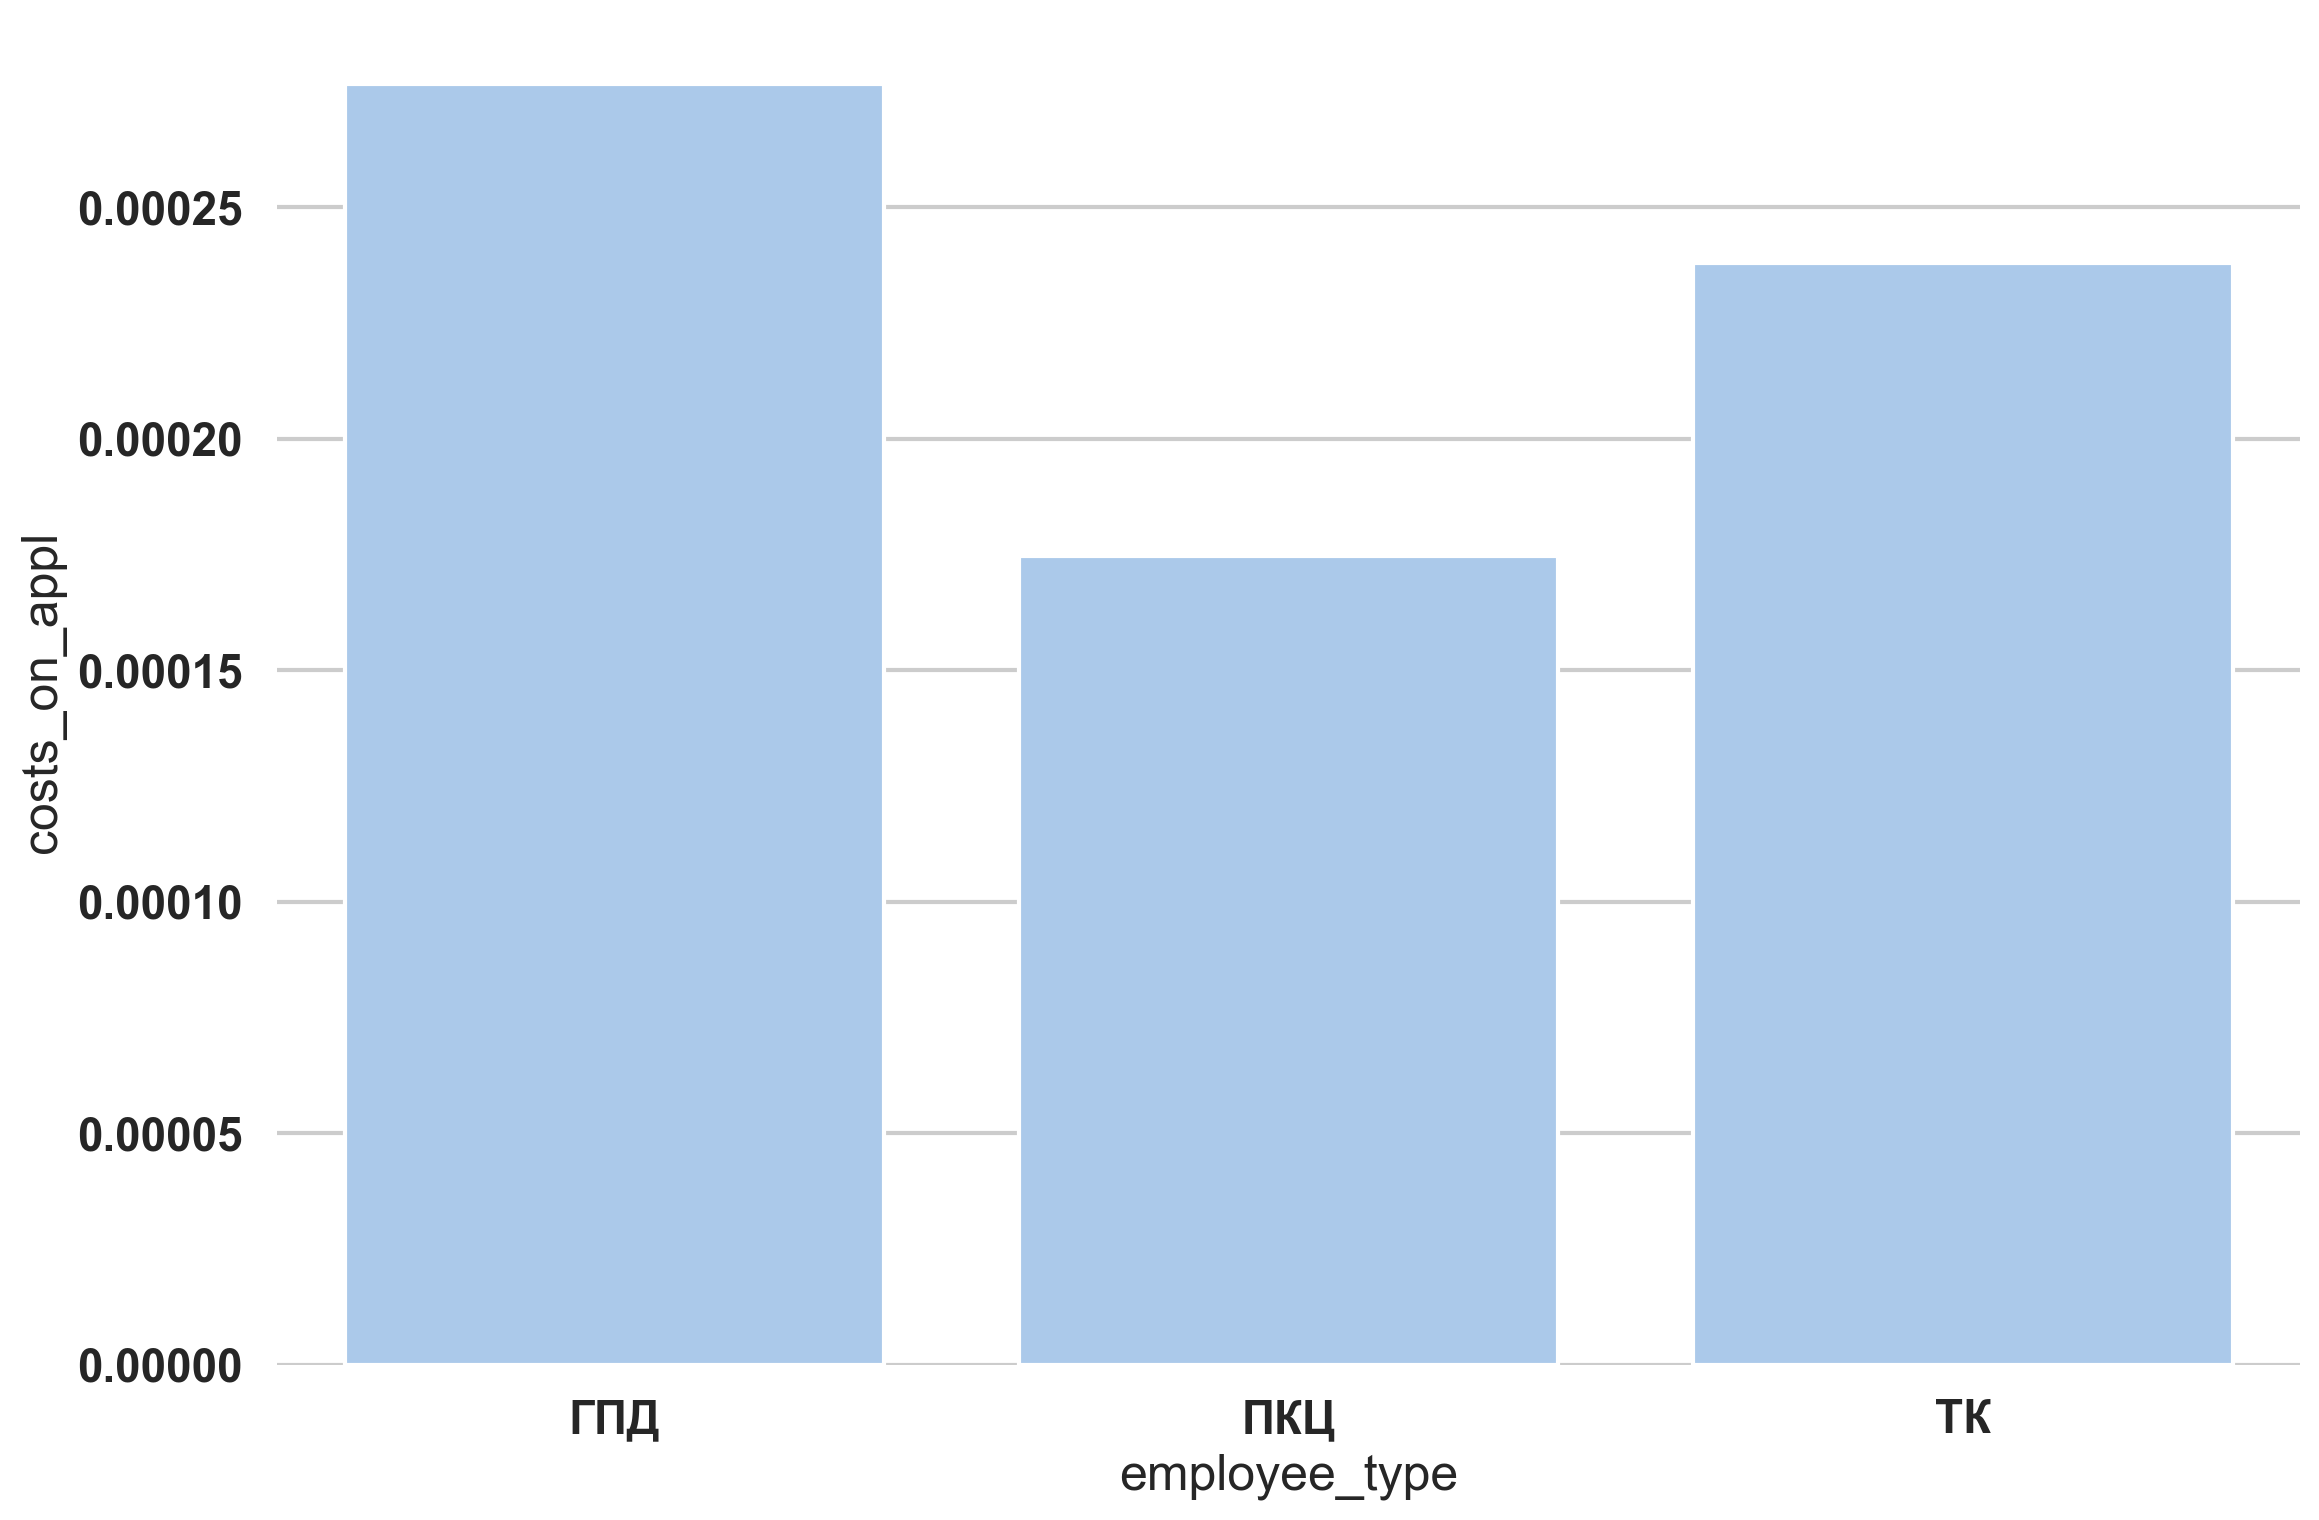

In [ ]:
df_forgr = df[df['employee_type'] != 'Прочие']
grouped = df_forgr.groupby('employee_type').agg({
    'application_flag' : 'mean',
    'employee_dialog_time_sec' : 'mean'
})
grouped['costs_on_appl'] = grouped['application_flag'] / grouped['employee_dialog_time_sec']
sns.barplot(x='employee_type', y='costs_on_appl', data=grouped)